# Comparison of Classification methods

Author: Dr. Vijesh J. Bhute   

<b>Highlights of this notebook:</b>
<ul><li>Performs classification of a dataset with more than 2 features.</li>
    <li> Compares different methods using Accuracy and Cumulative Accuracy Profile analysis. </li></ul>

<b>Outline of analysis</b>
<ul><li>Importing libraries</li>
    <li>Importing dataset and performing data check </li>
    <li>Splitting dataset into features and target</li>
    <li>Checking if encoding is needed and perform appropriate encoding in features and target </li>
    <li>Splitting the dataset into training and test (and validation if required)</li>
    <li>Performing feature scaling (if required)</li>
    <li>Optional: Perform dimensionality reduction using unsupervised methods such as PCA/kernel PCA if class information is already known</li>
    <li>Optional (not included in this code): Perform clustering to identify number of classes</li>
    <li>Build models. The different types of models included in this code are:</li>
    <ul><li>Logistical regression</li>
        <li>K-Nearest Neighbours</li>
        <li>Support vector machine (SVM)</li>
        <li>Kernel SVM</li>
        <li>Naive Bayes</li>
        <li>Decision Tree</li>
        <li>Random Forest</li>
        <li>XGBoost</li>
        <li>CatBoost</li>
        <li>ANN</li>
    </ul> 
    <li>Perform k-fold validation to get accuracy of models (except for ANN)</li>
    <li>Compare models based on accuracies to select the best algorithm</li>
    <li>Optimise hyperparameters using grid search</li>
</ul>

### Introduction: Important metrics for classification models

#### Accuracy and Confusion matrix 

For classification problems, accuracy for the model is given by, $$\text{Accuracy} =\frac{\text{TN+TP}}{\text{TN+FN+TP+FP}}$$ 

#### Confusion matrix

You can also look at the confusion matrix to see a summary of how the model has performed:
<table>
  <tr>
    <td></td>
    <th>Predicted No ($0$)</th>
    <th>Predicted Yes ($1$)</th>
  </tr>
  <tr>
    <th>Actual No ($0$)</th>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <th>Actual Yes ($1$)</th>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.metrics import auc, confusion_matrix, accuracy_score

### Defining functions to streamline several computations

#### CAP analysis: Metric for comparing models

CAP: Cumulative Accuracy Profile is often used to compare models as accuracy alone may not be an ideal metric. 
<br><br>
This requires evaluating accuracy ratio. 
<br><br>
The first method to analyse the CAP Curve is using Area Under Curve. Let’s consider area under random model as $a$. We calculate the Accuracy Rate using the following steps:
<ul><li>Calculate the area under the perfect model ($a_P$) till the random model ($a$)</li>
    <li>Calculate the area under the prediction model ($a_R$) till the random model ($a$)</li>
    <li>Calculate Accuracy Ratio (AR) $= a_R / a_P$</li></ul>
The closer the Accuracy Ratio is to 1, better is the model.
<br> CAP analysis is adapted from <a href="https://www.kaggle.com/code/rohandawar/cap-cumulative-accuracy-profile-analysis-1/notebook" target="_blank">Kaggle website</a>

Below function finds the Accuracy ratio by comparing model prediction to random and perfect model. It takes the actual values and model predictions as input and returns the accuracy ratio which can be used to compare different models. <br>
<b>Main Assumption for using this function</b>: The actual values (target, y) takes binary values (0 and 1). 

In [2]:
def CAP_analysis(y_actual, y_predict):
    total = len(y_actual)
    one_count = np.sum(y_actual)
    
    lm = [y for _,y in sorted(zip(y_predict,y_actual), reverse=True)]
    xaxis = np.arange(0, total+1)
    yaxis = np.append([0], np.cumsum(lm))
    
    # Area under Random Model
    a = auc([0, total], [0, one_count])

    # Area between Perfect and Random Model
    aP = auc([0, one_count, total], [0, one_count, one_count]) - a

    # Area between Trained and Random Model
    aR = auc(xaxis, yaxis) - a

    return aR / aP

### Importing the dataset

I am going to use a breast cancer dataset from UCI for comparing different models. 

In [69]:
dataset = pd.read_csv('data/Data_UCI_Breast cancer_classification.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB


<ul><li>Last column is a binary variable. This is already encoded as 2 (benign) or 4 (malignant) and it might be beneficial to make this 0 and 1 by further encoding using Label Encoder.</li>
    <li>First column is not relevant for modelling and should be excluded from the training and test set</li></ul>

In [4]:
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

### Optional: converting Class or target categorical variable

Encode target labels with value between 0 and n_classes-1.
<br>
This transformer should be used to encode target values or non-ordinal variables (such as gender)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # Use OrdinalEncoder if there is order in the variable
y= le.fit_transform (y)
#There is also ordinal encoder when variable is not only categorical but also has certain order (high, low for example)
sum(y)

239

### Optional: Converting non-ordinal categorical variables to multiple columns

Insert the index of the column that needs to be encoded. This column will be distrbuted to multiple columns taking binary values and moved to the front. 

In [6]:
#columnToBeEncoded = index 

#### One hot encoding

In [7]:
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder
#ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(),[columnToBeEncoded])] , remainder='passthrough')
##remainder is important otherwise all other columns will not be saved
#X_encoded = np.array(ct.fit_transform(X)) #np is used to convert the array to numpy array format 
##features should be in numpy array format for post processing and machine learning algorithms
#print(X_encoded)

### Splitting the dataset into the Training set and Test set

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
split_info = [len(y_train), len(y_test)]
split_info

[546, 137]

<b>Optional</b>: For large datasets, you can also split dataset into training, test, and validation set. You can train on training set, test on test set to assess overfitting and finally use validation set to compare multiple models. This can be done by using the below commands:

In [71]:
#from sklearn.model_selection import train_test_split
#X_2, X_test, y_2, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
#X_train, X_validate, y_train, y_validate = train_test_split(X_2, y_2, test_size = 0.12, random_state = 0)
#print(len(X_train[:,1]))

### Optional: Feature scaling (Essential if performing PCA or other dimensionality reduction)

Feature scaling should be performed on the training set. 

<ul><li>Feature scaling should be done after splitting data into training and test set. Otherwise it would lead to leakage of data from test set to training set which is not realistic when using new data. </li>
    <li>Feature scaling is important when there is an implicit relationship between independent and dependent variable. </li>
    <li>Feature scaling is not necessary when the features are already in 0 to 1 (similar order of magnitude)</li>
<br>
</ul>
There are two main types of scaling:<ul>
<li>
<b> Standardisation</b>: Autoscaling (subtract mean and divide by standard deviation, brings values between roughly -3 and 3)</li>
<li><b> Normalisation </b>: Subtract min and divide by max-min (brings values in the range of 0 to 1) <br></li></ul>
<b>Note</b>: Normalisation can be used when features are normally distributed. 
Standardisation works all the time!

In [72]:
from sklearn.preprocessing import StandardScaler
scaling = True
if scaling:
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

<b>Note:</b> The predictors/features are of similar orders of magnitude. If they were different, then it would have been important to perform feature scaling (especially since the following models will relate to classification based on these features and there isn't any explicit relationship between $y$ and $x$). 
<br>
In this case, it is also fine to do the feature scaling as it will ensure that all features have similar average and standard deviation<br>

### Optional: Dimensionality Reduction

### Apply PCA

Make sure that the features are scaled (auto-scaling)

Ideally, the number of components to be chosen should be assessed by using variance plot.

In [112]:
from sklearn.decomposition import PCA
num_components = len(X_train[1,:])
pca = PCA(n_components = num_components) #This creates two principal components
pc_train = pca.fit_transform(X_train)
pc_test = pca.transform(X_test)

In [113]:
variance_c1 = pca.explained_variance_ratio_[0]*100
variance_c2 = pca.explained_variance_ratio_[1]*100
variance = pca.explained_variance_ratio_*100
variance = np.array(variance)
np.cumsum(variance)

array([ 65.80136357,  74.50208862,  80.41255517,  85.40048205,
        89.50216624,  93.14262471,  96.376704  ,  98.99307558,
       100.        ])

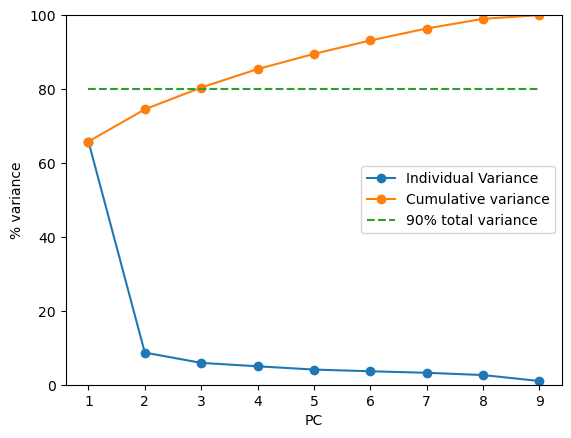

In [121]:
cutoff = 80
plt.plot(range(1,len(variance)+1), variance, '-o', label = 'Individual Variance')
plt.plot(range(1,len(variance)+1), np.cumsum(variance),'-o', label = 'Cumulative variance')
plt.plot(range(1,len(variance)+1), [cutoff]*len(variance),'--', label = '90% total variance')
plt.xlabel('PC')
plt.ylabel('% variance')
plt.ylim(0, 100)
plt.legend()

Based on above plot, it can be seen that it takes only 3 principal components to explain 80% of the variance. There are 9 features in the original dataset. Theoretically, first 3 principal components can be used for future analysis (with normal classification models except for ANN).

In [122]:
num_components = 3 #This is based on above variance analysis
pca = PCA(n_components = num_components) #This creates two principal components
pc_train = pca.fit_transform(X_train)
pc_test = pca.transform(X_test)

In [123]:
variance_c1 = pca.explained_variance_ratio_[0]*100
variance_c2 = pca.explained_variance_ratio_[1]*100
variance_c3 = pca.explained_variance_ratio_[2]*100
variance = pca.explained_variance_ratio_*100
variance = np.array(variance)
np.cumsum(variance)

array([65.80136357, 74.50208862, 80.41255517])

In [124]:
def classInfo(pca_components,yTarget): 
#yTarget takes binary values in this case. If there are more categories, modify this function accordingly
    n_comp = len(pca_components[1,:])
    pc_class_1 = np.empty((sum(yTarget),n_comp))
    pc_class_0 = np.empty((len(yTarget)-sum(yTarget),n_comp))
    count1 = 0
    count0 = 0
    for i in range(0,len(yTarget)):
        if(yTarget[i] == 1):
            pc_class_1[count1,:] = pca_components[i,:]
            count1=count1+1
        else:
            pc_class_0[count0] = pca_components[i,:]
            count0=count0+1
    return pc_class_1, pc_class_0

In [125]:
pc_train_1, pc_train_0 = classInfo(pc_train,y_train)
pc_test_1, pc_test_0 = classInfo(pc_test,y_test)

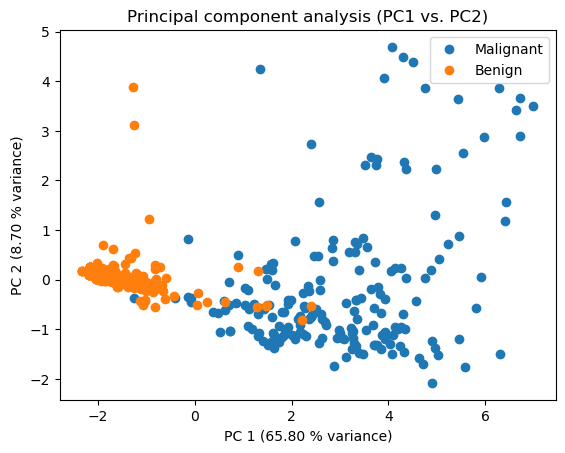

In [126]:
plt.plot(pc_train_1[:,0],pc_train_1[:,1], 'o', label = 'Malignant')
plt.plot(pc_train_0[:,0],pc_train_0[:,1], 'o', label = 'Benign')
plt.xlabel('PC 1 (%0.2f %% variance)' %variance_c1)
plt.ylabel('PC 2 (%0.2f %% variance)' %variance_c2)
plt.title('Principal component analysis (PC1 vs. PC2)')
plt.legend(loc = 'best')

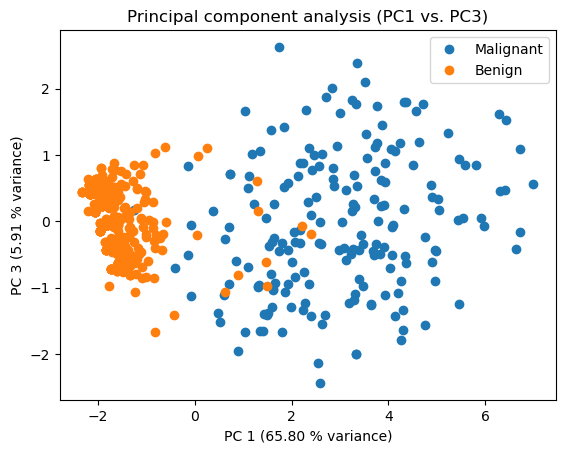

In [127]:
plt.plot(pc_train_1[:,0],pc_train_1[:,2], 'o', label = 'Malignant')
plt.plot(pc_train_0[:,0],pc_train_0[:,2], 'o', label = 'Benign')
plt.xlabel('PC 1 (%0.2f %% variance)' %variance_c1)
plt.ylabel('PC 3 (%0.2f %% variance)' %variance_c3)
plt.title('Principal component analysis (PC1 vs. PC3)')
plt.legend(loc = 'best')

PC1 vs. PC3 does a better job in separating malignant and benign group!

### Kernel PCA

Kernel PCA gives superior separation than normal PCA as it uses non-linear kernels.

In [133]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 3, kernel = 'rbf')
kpc_train = kpca.fit_transform(X_train)
kpc_test = kpca.transform(X_test)

Note that Kernel PCA doesn't have a variance attribute and can't be interpreted like normal PCA. 

In [134]:
kpc_train_1, kpc_train_0 = classInfo(kpc_train,y_train)
kpc_test_1, kpc_test_0 = classInfo(kpc_test,y_test)

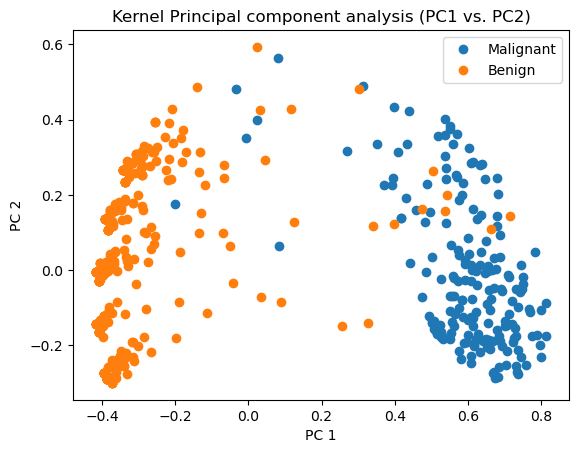

In [137]:
plt.plot(kpc_train_1[:,0],kpc_train_1[:,1], 'o', label = 'Malignant')
plt.plot(kpc_train_0[:,0],kpc_train_0[:,1], 'o', label = 'Benign')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Kernel Principal component analysis (PC1 vs. PC2)')
plt.legend(loc = 'best')

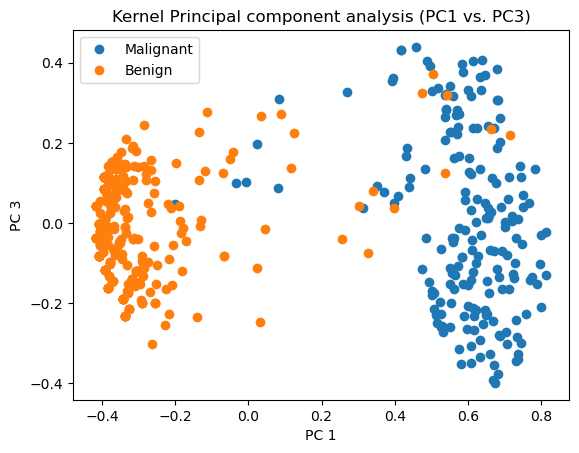

In [139]:
plt.plot(kpc_train_1[:,0],kpc_train_1[:,2], 'o', label = 'Malignant')
plt.plot(kpc_train_0[:,0],kpc_train_0[:,2], 'o', label = 'Benign')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('Kernel Principal component analysis (PC1 vs. PC3)')
plt.legend(loc = 'best')

## Logistic Regression

Multiple linear regression model is given by, $$ y = b_0 + b_1 *x_1 + b_2 *x_2$$
<br>In logistic regression, you fit a function which lies in $0-1$. For example, sigmoid function, which is given by, $$p = \frac{1}{1+e^{-y}}$$
<br> Where $p$ is the probability which takes the values between $0$ and $1$. Solving above equation for $y$, we get, $$y = \ln \Big(\frac{p}{1-p}\Big) = b_0 + b_1*x_1 + b_2*x_2$$

In [14]:
from sklearn.linear_model import LogisticRegression
logModel = LogisticRegression(random_state = 0)
logModel.fit(X_train, y_train)
y_predict_logModel= logModel.predict(X_test) #Predicting test set
cm = confusion_matrix(y_test, y_predict_logModel)
print(cm)

[[84  3]
 [ 3 47]]


## K Nearest Neighbours

In [15]:
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski',p=2) #minkowski with p=2 corresponds to Euclidean distance
kNN.fit(X_train, y_train)
y_predict_kNN=kNN.predict(X_test)
cm = confusion_matrix(y_test, y_predict_kNN)
print(cm)

[[83  4]
 [ 2 48]]


C:\Users\vbhute\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## Support Vector Machine (SVM)

### Linear kernel for SVM

In [16]:
from sklearn.svm import SVC
LinearSVMmodel = SVC(kernel='linear', random_state = 0)
LinearSVMmodel.fit(X_train, y_train)
y_predict_LinSVM=LinearSVMmodel.predict(X_test)
cm = confusion_matrix(y_test,y_predict_LinSVM)
print(cm)

[[83  4]
 [ 2 48]]


### Kernel SVM

Types of common kernel functions:<br>
<ul><li>Gaussian Radial basis function (RBF)</li>
    <li>Sigmoid kernel </li>
    <li>Polynomial kernel</li>
    </ul>

In [17]:
from sklearn.svm import SVC
kSVMmodel = SVC() #default kernel is rbf (radial basis function)
#Other kernels include 'linear', ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or callable, default=’rbf’
kSVMmodel.fit(X_train, y_train)
y_predict_kSVM=kSVMmodel.predict(X_test)
cm = confusion_matrix(y_test,y_predict_kSVM)
print(cm)

[[82  5]
 [ 1 49]]


## Naive Bayes

<ul><li>Naive Bayes makes several assumptions but can be used even if the dataset don't satisfy these assumptions. </li><li>The most important assumption is that the <b>features are linearly independent of each other</b>. This is not true in most cases.</li> <li>
In spite of their apparently over-simplified assumptions, naive Bayes classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. They require a small amount of training data to estimate the necessary parameters. </li>
    <li><b>This algorithm is good for classification but very good for estimation!</b></li>
<li>There are different types of Naive Bayes classifiers which differ mainly by the assumptions they make regarding the distribution of $P(x_i | y)$. These are:
<ul><li> Gaussian Naive Bayes</li>
    <li> Multinomial Naive Bayes </li>
    <li> Complement Naive Bayes</li>
    <li> Bernoulli Naive Bayes</li>
    <li> Categorical Naive Bayes </li></ul></li></ul>
You can learn more about Naive Bayes classifier from <a href="https://scikit-learn.org/stable/modules/naive_bayes.html" target="_blank">scikit learn website</a> <br>

### Gaussian Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB #MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
NBmodel = GaussianNB()
NBmodel.fit(X_train,y_train)
y_predict_NB= NBmodel.predict(X_test)
cm = confusion_matrix(y_test,y_predict_NB)
print(cm)

[[80  7]
 [ 0 50]]


### Decision Trees classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier
DecTreeModel= DecisionTreeClassifier()
DecTreeModel.fit(X_train,y_train)
y_predict_DecTree= DecTreeModel.predict(X_test)
cm = confusion_matrix(y_test,y_predict_DecTree)
print(cm)

[[81  6]
 [ 1 49]]


## Random Forests classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
RFModel = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
RFModel.fit(X_train, y_train)
y_predict_RF= RFModel.predict(X_test)
cm = confusion_matrix(y_test,y_predict_RF)
print(cm)

[[84  3]
 [ 1 49]]


## XGBoost

In [21]:
#!pip install xgboost #Use this if xgboost is not already installed

In [22]:
from xgboost import XGBClassifier
XGBmodel = XGBClassifier()
XGBmodel.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix, accuracy_score
y_predict_XGB = XGBmodel.predict(X_test)
cm = confusion_matrix(y_test, y_predict_XGB)
print(cm)
#accuracy_score(y_test, y_pred)

C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:44:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[84  3]
 [ 1 49]]


## CatBoost

In [23]:
#May need to install catboost via Anaconda using the cmd by using the following command: conda install catboost
from catboost import CatBoostClassifier
CatBoostmodel = CatBoostClassifier()
CatBoostmodel.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix, accuracy_score
y_predict_CatB = CatBoostmodel.predict(X_test)
cm = confusion_matrix(y_test, y_predict_CatB)
print(cm)
#accuracy_score(y_test, y_pred)

Learning rate set to 0.007956
0:	learn: 0.6773044	total: 171ms	remaining: 2m 50s
1:	learn: 0.6597970	total: 175ms	remaining: 1m 27s
2:	learn: 0.6444872	total: 178ms	remaining: 59.3s
3:	learn: 0.6292693	total: 181ms	remaining: 45s
4:	learn: 0.6167804	total: 184ms	remaining: 36.5s
5:	learn: 0.6006776	total: 187ms	remaining: 31s
6:	learn: 0.5863011	total: 190ms	remaining: 26.9s
7:	learn: 0.5719487	total: 192ms	remaining: 23.8s
8:	learn: 0.5584160	total: 195ms	remaining: 21.5s
9:	learn: 0.5444026	total: 198ms	remaining: 19.6s
10:	learn: 0.5324566	total: 201ms	remaining: 18.1s
11:	learn: 0.5230008	total: 203ms	remaining: 16.7s
12:	learn: 0.5107659	total: 207ms	remaining: 15.7s
13:	learn: 0.4993509	total: 210ms	remaining: 14.8s
14:	learn: 0.4890183	total: 213ms	remaining: 14s
15:	learn: 0.4798578	total: 216ms	remaining: 13.3s
16:	learn: 0.4688945	total: 219ms	remaining: 12.7s
17:	learn: 0.4603259	total: 222ms	remaining: 12.1s
18:	learn: 0.4500329	total: 224ms	remaining: 11.6s
19:	learn: 0.43

179:	learn: 0.0739203	total: 662ms	remaining: 3.02s
180:	learn: 0.0735907	total: 666ms	remaining: 3.01s
181:	learn: 0.0732922	total: 668ms	remaining: 3s
182:	learn: 0.0728550	total: 671ms	remaining: 3s
183:	learn: 0.0725107	total: 674ms	remaining: 2.99s
184:	learn: 0.0721008	total: 676ms	remaining: 2.98s
185:	learn: 0.0716339	total: 679ms	remaining: 2.97s
186:	learn: 0.0711830	total: 682ms	remaining: 2.96s
187:	learn: 0.0707780	total: 685ms	remaining: 2.96s
188:	learn: 0.0704894	total: 687ms	remaining: 2.95s
189:	learn: 0.0700585	total: 690ms	remaining: 2.94s
190:	learn: 0.0696374	total: 693ms	remaining: 2.93s
191:	learn: 0.0691702	total: 696ms	remaining: 2.93s
192:	learn: 0.0688439	total: 698ms	remaining: 2.92s
193:	learn: 0.0686534	total: 701ms	remaining: 2.91s
194:	learn: 0.0683096	total: 703ms	remaining: 2.9s
195:	learn: 0.0681264	total: 706ms	remaining: 2.9s
196:	learn: 0.0677510	total: 708ms	remaining: 2.89s
197:	learn: 0.0674315	total: 711ms	remaining: 2.88s
198:	learn: 0.067138

369:	learn: 0.0370925	total: 1.15s	remaining: 1.96s
370:	learn: 0.0370126	total: 1.16s	remaining: 1.96s
371:	learn: 0.0369622	total: 1.16s	remaining: 1.96s
372:	learn: 0.0368820	total: 1.16s	remaining: 1.95s
373:	learn: 0.0367961	total: 1.16s	remaining: 1.95s
374:	learn: 0.0367255	total: 1.16s	remaining: 1.94s
375:	learn: 0.0366170	total: 1.17s	remaining: 1.93s
376:	learn: 0.0365685	total: 1.17s	remaining: 1.93s
377:	learn: 0.0364173	total: 1.17s	remaining: 1.92s
378:	learn: 0.0363469	total: 1.17s	remaining: 1.92s
379:	learn: 0.0362842	total: 1.17s	remaining: 1.91s
380:	learn: 0.0361423	total: 1.17s	remaining: 1.91s
381:	learn: 0.0360365	total: 1.18s	remaining: 1.9s
382:	learn: 0.0359473	total: 1.18s	remaining: 1.9s
383:	learn: 0.0358793	total: 1.18s	remaining: 1.89s
384:	learn: 0.0358010	total: 1.18s	remaining: 1.89s
385:	learn: 0.0357200	total: 1.19s	remaining: 1.89s
386:	learn: 0.0356575	total: 1.19s	remaining: 1.88s
387:	learn: 0.0354912	total: 1.19s	remaining: 1.88s
388:	learn: 0.

559:	learn: 0.0239891	total: 1.64s	remaining: 1.29s
560:	learn: 0.0239285	total: 1.64s	remaining: 1.28s
561:	learn: 0.0238704	total: 1.64s	remaining: 1.28s
562:	learn: 0.0237851	total: 1.65s	remaining: 1.28s
563:	learn: 0.0237504	total: 1.65s	remaining: 1.27s
564:	learn: 0.0236995	total: 1.65s	remaining: 1.27s
565:	learn: 0.0236531	total: 1.65s	remaining: 1.26s
566:	learn: 0.0236234	total: 1.65s	remaining: 1.26s
567:	learn: 0.0235639	total: 1.65s	remaining: 1.26s
568:	learn: 0.0235252	total: 1.66s	remaining: 1.25s
569:	learn: 0.0234715	total: 1.66s	remaining: 1.25s
570:	learn: 0.0234370	total: 1.66s	remaining: 1.25s
571:	learn: 0.0233626	total: 1.66s	remaining: 1.24s
572:	learn: 0.0233413	total: 1.66s	remaining: 1.24s
573:	learn: 0.0232798	total: 1.66s	remaining: 1.24s
574:	learn: 0.0232444	total: 1.67s	remaining: 1.23s
575:	learn: 0.0231930	total: 1.67s	remaining: 1.23s
576:	learn: 0.0231306	total: 1.67s	remaining: 1.23s
577:	learn: 0.0230592	total: 1.68s	remaining: 1.22s
578:	learn: 

741:	learn: 0.0169052	total: 2.13s	remaining: 741ms
742:	learn: 0.0168699	total: 2.13s	remaining: 738ms
743:	learn: 0.0168237	total: 2.14s	remaining: 735ms
744:	learn: 0.0167992	total: 2.14s	remaining: 732ms
745:	learn: 0.0167251	total: 2.14s	remaining: 729ms
746:	learn: 0.0166976	total: 2.14s	remaining: 726ms
747:	learn: 0.0166707	total: 2.14s	remaining: 723ms
748:	learn: 0.0166396	total: 2.15s	remaining: 719ms
749:	learn: 0.0166068	total: 2.15s	remaining: 716ms
750:	learn: 0.0165998	total: 2.15s	remaining: 713ms
751:	learn: 0.0165832	total: 2.15s	remaining: 710ms
752:	learn: 0.0165454	total: 2.15s	remaining: 707ms
753:	learn: 0.0165258	total: 2.16s	remaining: 704ms
754:	learn: 0.0164881	total: 2.16s	remaining: 701ms
755:	learn: 0.0164536	total: 2.16s	remaining: 698ms
756:	learn: 0.0164120	total: 2.16s	remaining: 695ms
757:	learn: 0.0163748	total: 2.17s	remaining: 692ms
758:	learn: 0.0163599	total: 2.17s	remaining: 689ms
759:	learn: 0.0163352	total: 2.17s	remaining: 686ms
760:	learn: 

930:	learn: 0.0120734	total: 2.62s	remaining: 195ms
931:	learn: 0.0120668	total: 2.63s	remaining: 192ms
932:	learn: 0.0120463	total: 2.63s	remaining: 189ms
933:	learn: 0.0120249	total: 2.63s	remaining: 186ms
934:	learn: 0.0120032	total: 2.64s	remaining: 183ms
935:	learn: 0.0119781	total: 2.64s	remaining: 181ms
936:	learn: 0.0119618	total: 2.64s	remaining: 178ms
937:	learn: 0.0119481	total: 2.65s	remaining: 175ms
938:	learn: 0.0119303	total: 2.65s	remaining: 172ms
939:	learn: 0.0119169	total: 2.65s	remaining: 169ms
940:	learn: 0.0119056	total: 2.65s	remaining: 167ms
941:	learn: 0.0118857	total: 2.66s	remaining: 164ms
942:	learn: 0.0118614	total: 2.66s	remaining: 161ms
943:	learn: 0.0118388	total: 2.66s	remaining: 158ms
944:	learn: 0.0118188	total: 2.67s	remaining: 155ms
945:	learn: 0.0118052	total: 2.67s	remaining: 152ms
946:	learn: 0.0117889	total: 2.67s	remaining: 149ms
947:	learn: 0.0117633	total: 2.67s	remaining: 147ms
948:	learn: 0.0117391	total: 2.68s	remaining: 144ms
949:	learn: 

### ANN

In [24]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [25]:
# Initializing the ANN

annModel = tf.keras.models.Sequential() #initialise the neural network framework

# Building hidden layer

annModel.add(tf.keras.layers.Dense(units = 6, activation = 'relu')) 
#6 neurons in this hidden layer, rectifier activation function

# Building 2nd hidden layer

annModel.add(tf.keras.layers.Dense(units = 6, activation = 'relu')) 
#6 neurons in this hidden layer, rectifier activation function

# Adding output layer

annModel.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid')) 
#1 neuron for binary prediction, sigmoid activation function to get a final choice of 0 or 1
#For non-binary classification, activation should be softmax

# Training ANN

# Compile ANN

annModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) 
#adam can perform stochastic gradient descent (update weights in each iteration to minimise the loss(error))
#binary or categorical cross entropy as the loss function
#Multiple metrics can be chosen, hence list is used

# Training

annModel.fit(X_train, y_train, batch_size = 32, epochs = 100)
#batch size is the number of entries which are used in batch learning

Epoch 1/100
18/18 [==============================] - 2s 3ms/step - loss: 1.0592 - accuracy: 0.3462
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.9148 - accuracy: 0.3462
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.8116 - accuracy: 0.3462
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.7342 - accuracy: 0.3462
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.3425
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.3443
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6053 - accuracy: 0.3480
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 0.5777 - accuracy: 0.3535
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 0.5545 - accuracy: 0.3718
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 0.5339 - accuracy: 0.4505
Epoch 11/

18/18 [==============================] - 0s 4ms/step - loss: 0.2288 - accuracy: 0.9744
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2264 - accuracy: 0.9744
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 0.2244 - accuracy: 0.9744
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2223 - accuracy: 0.9744
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2204 - accuracy: 0.9744
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2185 - accuracy: 0.9744
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2172 - accuracy: 0.9744
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2155 - accuracy: 0.9744
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2137 - accuracy: 0.9744
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2121 - accuracy: 0.9744
Epoch 93/100


In [26]:
def predict_binary(model, X, scaled, sc):
    if scaled == 0:
        X = sc.transform(X)
    
    y_predict = model.predict(X)
    
    y_predict_binary = [0]*len(y_predict)
    for i in range(0,len(y_predict)):
        if(y_predict[i]>0.5):
            y_predict_binary[i] = 1
        else:
            y_predict_binary[i] = 0
    return y_predict_binary

In [27]:
y_predict_ANN_test = predict_binary(annModel, X_test, 1, sc)
y_predict_ANN_train = predict_binary(annModel, X_train, 1, sc)

18/18 [==============================] - 0s 3ms/step


### k-fold Cross-validation

In [28]:
kfold = 10

In [29]:
from sklearn.model_selection import cross_val_score
accuraciesLog = cross_val_score(estimator = logModel, X=X_train, y=y_train, cv=kfold)
accuracieskNN = cross_val_score(estimator = kNN, X=X_train, y=y_train, cv=kfold)
accuraciesLSVM = cross_val_score(estimator = LinearSVMmodel, X=X_train, y=y_train, cv=kfold)
accuraciesKSVM = cross_val_score(estimator = kSVMmodel, X=X_train, y=y_train, cv=kfold)
accuraciesNB = cross_val_score(estimator = NBmodel, X=X_train, y=y_train, cv=kfold)
accuraciesDT = cross_val_score(estimator = DecTreeModel, X=X_train, y=y_train, cv=kfold)
accuraciesRF = cross_val_score(estimator = RFModel, X=X_train, y=y_train, cv=kfold)
accuraciesXGB = cross_val_score(estimator = XGBmodel, X=X_train, y=y_train, cv=kfold)
accuraciesCatB = cross_val_score(estimator = CatBoostmodel, X=X_train, y=y_train, cv=kfold)
#print("Accuracy: {:.2f} %".format(accuraciesLog.mean()*100))
#print("Standard Deviation: {:.2f} %".format(accuraciesLog.std()*100))

C:\Users\vbhute\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\vbhute\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

[21:45:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:45:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\vbhute\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.007604
0:	learn: 0.6773603	total: 1.49ms	remaining: 1.48s
1:	learn: 0.6638265	total: 3.36ms	remaining: 1.68s
2:	learn: 0.6487768	total: 5.25ms	remaining: 1.74s
3:	learn: 0.6331716	total: 7.15ms	remaining: 1.78s
4:	learn: 0.6208047	total: 8.89ms	remaining: 1.77s
5:	learn: 0.6054731	total: 10.7ms	remaining: 1.78s
6:	learn: 0.5903624	total: 13ms	remaining: 1.85s
7:	learn: 0.5763344	total: 16.1ms	remaining: 1.99s
8:	learn: 0.5653777	total: 18.5ms	remaining: 2.04s
9:	learn: 0.5531434	total: 20.9ms	remaining: 2.06s
10:	learn: 0.5417318	total: 23.5ms	remaining: 2.11s
11:	learn: 0.5322945	total: 25.2ms	remaining: 2.07s
12:	learn: 0.5185134	total: 27.

204:	learn: 0.0633604	total: 486ms	remaining: 1.88s
205:	learn: 0.0631544	total: 489ms	remaining: 1.88s
206:	learn: 0.0628676	total: 491ms	remaining: 1.88s
207:	learn: 0.0625259	total: 494ms	remaining: 1.88s
208:	learn: 0.0621996	total: 496ms	remaining: 1.88s
209:	learn: 0.0620049	total: 498ms	remaining: 1.87s
210:	learn: 0.0616889	total: 500ms	remaining: 1.87s
211:	learn: 0.0613507	total: 502ms	remaining: 1.86s
212:	learn: 0.0609759	total: 504ms	remaining: 1.86s
213:	learn: 0.0607645	total: 505ms	remaining: 1.85s
214:	learn: 0.0604390	total: 507ms	remaining: 1.85s
215:	learn: 0.0601774	total: 509ms	remaining: 1.85s
216:	learn: 0.0599244	total: 510ms	remaining: 1.84s
217:	learn: 0.0596546	total: 512ms	remaining: 1.84s
218:	learn: 0.0593929	total: 514ms	remaining: 1.83s
219:	learn: 0.0591276	total: 516ms	remaining: 1.83s
220:	learn: 0.0588434	total: 519ms	remaining: 1.83s
221:	learn: 0.0587318	total: 520ms	remaining: 1.82s
222:	learn: 0.0584758	total: 523ms	remaining: 1.82s
223:	learn: 

394:	learn: 0.0332807	total: 971ms	remaining: 1.49s
395:	learn: 0.0332221	total: 974ms	remaining: 1.49s
396:	learn: 0.0331448	total: 976ms	remaining: 1.48s
397:	learn: 0.0331023	total: 978ms	remaining: 1.48s
398:	learn: 0.0330334	total: 979ms	remaining: 1.48s
399:	learn: 0.0329405	total: 981ms	remaining: 1.47s
400:	learn: 0.0328419	total: 983ms	remaining: 1.47s
401:	learn: 0.0327621	total: 985ms	remaining: 1.47s
402:	learn: 0.0326980	total: 987ms	remaining: 1.46s
403:	learn: 0.0326237	total: 989ms	remaining: 1.46s
404:	learn: 0.0325486	total: 991ms	remaining: 1.46s
405:	learn: 0.0325190	total: 992ms	remaining: 1.45s
406:	learn: 0.0324762	total: 994ms	remaining: 1.45s
407:	learn: 0.0324330	total: 997ms	remaining: 1.45s
408:	learn: 0.0323678	total: 1000ms	remaining: 1.44s
409:	learn: 0.0322528	total: 1s	remaining: 1.44s
410:	learn: 0.0321902	total: 1s	remaining: 1.44s
411:	learn: 0.0321066	total: 1.01s	remaining: 1.44s
412:	learn: 0.0320407	total: 1.01s	remaining: 1.44s
413:	learn: 0.031

575:	learn: 0.0220054	total: 1.45s	remaining: 1.07s
576:	learn: 0.0219638	total: 1.45s	remaining: 1.06s
577:	learn: 0.0219199	total: 1.46s	remaining: 1.06s
578:	learn: 0.0218966	total: 1.46s	remaining: 1.06s
579:	learn: 0.0218612	total: 1.46s	remaining: 1.06s
580:	learn: 0.0218155	total: 1.46s	remaining: 1.05s
581:	learn: 0.0217863	total: 1.47s	remaining: 1.05s
582:	learn: 0.0217465	total: 1.47s	remaining: 1.05s
583:	learn: 0.0216984	total: 1.47s	remaining: 1.05s
584:	learn: 0.0216491	total: 1.47s	remaining: 1.04s
585:	learn: 0.0215982	total: 1.47s	remaining: 1.04s
586:	learn: 0.0215524	total: 1.48s	remaining: 1.04s
587:	learn: 0.0214918	total: 1.48s	remaining: 1.03s
588:	learn: 0.0214617	total: 1.48s	remaining: 1.03s
589:	learn: 0.0214166	total: 1.49s	remaining: 1.04s
590:	learn: 0.0213492	total: 1.49s	remaining: 1.03s
591:	learn: 0.0213120	total: 1.5s	remaining: 1.03s
592:	learn: 0.0212852	total: 1.5s	remaining: 1.03s
593:	learn: 0.0212499	total: 1.5s	remaining: 1.02s
594:	learn: 0.0

751:	learn: 0.0159542	total: 1.94s	remaining: 638ms
752:	learn: 0.0159133	total: 1.94s	remaining: 636ms
753:	learn: 0.0158684	total: 1.94s	remaining: 633ms
754:	learn: 0.0158232	total: 1.94s	remaining: 631ms
755:	learn: 0.0157864	total: 1.95s	remaining: 628ms
756:	learn: 0.0157517	total: 1.95s	remaining: 626ms
757:	learn: 0.0157236	total: 1.95s	remaining: 623ms
758:	learn: 0.0157049	total: 1.96s	remaining: 621ms
759:	learn: 0.0156920	total: 1.96s	remaining: 619ms
760:	learn: 0.0156704	total: 1.96s	remaining: 616ms
761:	learn: 0.0156339	total: 1.96s	remaining: 614ms
762:	learn: 0.0156125	total: 1.97s	remaining: 611ms
763:	learn: 0.0155836	total: 1.97s	remaining: 609ms
764:	learn: 0.0155676	total: 1.97s	remaining: 606ms
765:	learn: 0.0155431	total: 1.98s	remaining: 604ms
766:	learn: 0.0155109	total: 1.98s	remaining: 602ms
767:	learn: 0.0154924	total: 1.98s	remaining: 599ms
768:	learn: 0.0154555	total: 1.99s	remaining: 596ms
769:	learn: 0.0154168	total: 1.99s	remaining: 594ms
770:	learn: 

911:	learn: 0.0120433	total: 2.26s	remaining: 218ms
912:	learn: 0.0120265	total: 2.26s	remaining: 215ms
913:	learn: 0.0120123	total: 2.26s	remaining: 213ms
914:	learn: 0.0119980	total: 2.26s	remaining: 210ms
915:	learn: 0.0119778	total: 2.26s	remaining: 208ms
916:	learn: 0.0119462	total: 2.27s	remaining: 205ms
917:	learn: 0.0119304	total: 2.27s	remaining: 203ms
918:	learn: 0.0119107	total: 2.27s	remaining: 200ms
919:	learn: 0.0118950	total: 2.27s	remaining: 197ms
920:	learn: 0.0118687	total: 2.27s	remaining: 195ms
921:	learn: 0.0118502	total: 2.27s	remaining: 192ms
922:	learn: 0.0118274	total: 2.27s	remaining: 190ms
923:	learn: 0.0118081	total: 2.28s	remaining: 187ms
924:	learn: 0.0117894	total: 2.28s	remaining: 185ms
925:	learn: 0.0117694	total: 2.28s	remaining: 182ms
926:	learn: 0.0117529	total: 2.28s	remaining: 180ms
927:	learn: 0.0117256	total: 2.28s	remaining: 177ms
928:	learn: 0.0117098	total: 2.29s	remaining: 175ms
929:	learn: 0.0116962	total: 2.29s	remaining: 172ms
930:	learn: 

82:	learn: 0.1583497	total: 147ms	remaining: 1.63s
83:	learn: 0.1565965	total: 149ms	remaining: 1.63s
84:	learn: 0.1546404	total: 151ms	remaining: 1.63s
85:	learn: 0.1527283	total: 153ms	remaining: 1.63s
86:	learn: 0.1508542	total: 155ms	remaining: 1.62s
87:	learn: 0.1492654	total: 157ms	remaining: 1.62s
88:	learn: 0.1476989	total: 158ms	remaining: 1.62s
89:	learn: 0.1462374	total: 160ms	remaining: 1.62s
90:	learn: 0.1446420	total: 162ms	remaining: 1.62s
91:	learn: 0.1428684	total: 164ms	remaining: 1.61s
92:	learn: 0.1409876	total: 165ms	remaining: 1.61s
93:	learn: 0.1390318	total: 167ms	remaining: 1.61s
94:	learn: 0.1375343	total: 169ms	remaining: 1.61s
95:	learn: 0.1362877	total: 170ms	remaining: 1.6s
96:	learn: 0.1349102	total: 172ms	remaining: 1.6s
97:	learn: 0.1330769	total: 174ms	remaining: 1.6s
98:	learn: 0.1314735	total: 176ms	remaining: 1.6s
99:	learn: 0.1302147	total: 178ms	remaining: 1.6s
100:	learn: 0.1287860	total: 180ms	remaining: 1.6s
101:	learn: 0.1273032	total: 182ms	r

252:	learn: 0.0488940	total: 470ms	remaining: 1.39s
253:	learn: 0.0486283	total: 472ms	remaining: 1.39s
254:	learn: 0.0484325	total: 474ms	remaining: 1.38s
255:	learn: 0.0482153	total: 476ms	remaining: 1.38s
256:	learn: 0.0480046	total: 478ms	remaining: 1.38s
257:	learn: 0.0478037	total: 480ms	remaining: 1.38s
258:	learn: 0.0476476	total: 483ms	remaining: 1.38s
259:	learn: 0.0473898	total: 485ms	remaining: 1.38s
260:	learn: 0.0471845	total: 487ms	remaining: 1.38s
261:	learn: 0.0470035	total: 489ms	remaining: 1.38s
262:	learn: 0.0468126	total: 490ms	remaining: 1.37s
263:	learn: 0.0466827	total: 492ms	remaining: 1.37s
264:	learn: 0.0465424	total: 497ms	remaining: 1.38s
265:	learn: 0.0464174	total: 499ms	remaining: 1.38s
266:	learn: 0.0463095	total: 502ms	remaining: 1.38s
267:	learn: 0.0460634	total: 504ms	remaining: 1.38s
268:	learn: 0.0457898	total: 506ms	remaining: 1.37s
269:	learn: 0.0456258	total: 510ms	remaining: 1.38s
270:	learn: 0.0454138	total: 514ms	remaining: 1.38s
271:	learn: 

455:	learn: 0.0256057	total: 948ms	remaining: 1.13s
456:	learn: 0.0255328	total: 951ms	remaining: 1.13s
457:	learn: 0.0254615	total: 953ms	remaining: 1.13s
458:	learn: 0.0254186	total: 955ms	remaining: 1.13s
459:	learn: 0.0253399	total: 957ms	remaining: 1.12s
460:	learn: 0.0253087	total: 959ms	remaining: 1.12s
461:	learn: 0.0252555	total: 963ms	remaining: 1.12s
462:	learn: 0.0251968	total: 966ms	remaining: 1.12s
463:	learn: 0.0251684	total: 967ms	remaining: 1.12s
464:	learn: 0.0250979	total: 969ms	remaining: 1.11s
465:	learn: 0.0250259	total: 971ms	remaining: 1.11s
466:	learn: 0.0249795	total: 973ms	remaining: 1.11s
467:	learn: 0.0249450	total: 975ms	remaining: 1.11s
468:	learn: 0.0248626	total: 977ms	remaining: 1.11s
469:	learn: 0.0248105	total: 980ms	remaining: 1.1s
470:	learn: 0.0247227	total: 982ms	remaining: 1.1s
471:	learn: 0.0246789	total: 984ms	remaining: 1.1s
472:	learn: 0.0246043	total: 986ms	remaining: 1.1s
473:	learn: 0.0245577	total: 988ms	remaining: 1.1s
474:	learn: 0.024

698:	learn: 0.0154119	total: 1.43s	remaining: 615ms
699:	learn: 0.0153691	total: 1.43s	remaining: 613ms
700:	learn: 0.0153285	total: 1.43s	remaining: 612ms
701:	learn: 0.0153146	total: 1.44s	remaining: 609ms
702:	learn: 0.0152864	total: 1.44s	remaining: 607ms
703:	learn: 0.0152710	total: 1.44s	remaining: 605ms
704:	learn: 0.0152474	total: 1.44s	remaining: 603ms
705:	learn: 0.0152192	total: 1.44s	remaining: 601ms
706:	learn: 0.0151922	total: 1.44s	remaining: 599ms
707:	learn: 0.0151742	total: 1.45s	remaining: 596ms
708:	learn: 0.0151482	total: 1.45s	remaining: 594ms
709:	learn: 0.0151266	total: 1.45s	remaining: 592ms
710:	learn: 0.0150882	total: 1.45s	remaining: 590ms
711:	learn: 0.0150590	total: 1.45s	remaining: 588ms
712:	learn: 0.0150200	total: 1.46s	remaining: 586ms
713:	learn: 0.0149947	total: 1.46s	remaining: 584ms
714:	learn: 0.0149758	total: 1.46s	remaining: 582ms
715:	learn: 0.0149590	total: 1.46s	remaining: 580ms
716:	learn: 0.0149230	total: 1.46s	remaining: 578ms
717:	learn: 

881:	learn: 0.0110723	total: 1.75s	remaining: 235ms
882:	learn: 0.0110566	total: 1.76s	remaining: 233ms
883:	learn: 0.0110392	total: 1.76s	remaining: 231ms
884:	learn: 0.0110288	total: 1.76s	remaining: 229ms
885:	learn: 0.0110175	total: 1.76s	remaining: 227ms
886:	learn: 0.0110074	total: 1.76s	remaining: 225ms
887:	learn: 0.0109918	total: 1.76s	remaining: 223ms
888:	learn: 0.0109654	total: 1.77s	remaining: 221ms
889:	learn: 0.0109527	total: 1.77s	remaining: 219ms
890:	learn: 0.0109426	total: 1.77s	remaining: 217ms
891:	learn: 0.0109300	total: 1.77s	remaining: 215ms
892:	learn: 0.0109128	total: 1.77s	remaining: 213ms
893:	learn: 0.0108918	total: 1.77s	remaining: 210ms
894:	learn: 0.0108672	total: 1.78s	remaining: 209ms
895:	learn: 0.0108447	total: 1.78s	remaining: 207ms
896:	learn: 0.0108183	total: 1.78s	remaining: 205ms
897:	learn: 0.0107993	total: 1.78s	remaining: 203ms
898:	learn: 0.0107769	total: 1.78s	remaining: 200ms
899:	learn: 0.0107549	total: 1.79s	remaining: 198ms
900:	learn: 

102:	learn: 0.1338229	total: 222ms	remaining: 1.93s
103:	learn: 0.1327610	total: 225ms	remaining: 1.94s
104:	learn: 0.1311989	total: 228ms	remaining: 1.94s
105:	learn: 0.1297597	total: 230ms	remaining: 1.94s
106:	learn: 0.1284313	total: 232ms	remaining: 1.93s
107:	learn: 0.1270232	total: 234ms	remaining: 1.93s
108:	learn: 0.1257868	total: 236ms	remaining: 1.93s
109:	learn: 0.1244475	total: 238ms	remaining: 1.92s
110:	learn: 0.1232917	total: 241ms	remaining: 1.93s
111:	learn: 0.1220622	total: 243ms	remaining: 1.93s
112:	learn: 0.1209913	total: 245ms	remaining: 1.92s
113:	learn: 0.1200469	total: 246ms	remaining: 1.92s
114:	learn: 0.1189543	total: 248ms	remaining: 1.91s
115:	learn: 0.1179564	total: 250ms	remaining: 1.9s
116:	learn: 0.1169309	total: 252ms	remaining: 1.9s
117:	learn: 0.1157639	total: 254ms	remaining: 1.9s
118:	learn: 0.1148615	total: 256ms	remaining: 1.9s
119:	learn: 0.1139593	total: 258ms	remaining: 1.89s
120:	learn: 0.1131088	total: 260ms	remaining: 1.89s
121:	learn: 0.11

313:	learn: 0.0452687	total: 694ms	remaining: 1.52s
314:	learn: 0.0451297	total: 697ms	remaining: 1.51s
315:	learn: 0.0449244	total: 699ms	remaining: 1.51s
316:	learn: 0.0448017	total: 702ms	remaining: 1.51s
317:	learn: 0.0447041	total: 705ms	remaining: 1.51s
318:	learn: 0.0445691	total: 708ms	remaining: 1.51s
319:	learn: 0.0444628	total: 710ms	remaining: 1.51s
320:	learn: 0.0443428	total: 712ms	remaining: 1.5s
321:	learn: 0.0442301	total: 714ms	remaining: 1.5s
322:	learn: 0.0441239	total: 717ms	remaining: 1.5s
323:	learn: 0.0439872	total: 718ms	remaining: 1.5s
324:	learn: 0.0438779	total: 720ms	remaining: 1.5s
325:	learn: 0.0437622	total: 722ms	remaining: 1.49s
326:	learn: 0.0435863	total: 724ms	remaining: 1.49s
327:	learn: 0.0434226	total: 726ms	remaining: 1.49s
328:	learn: 0.0433197	total: 728ms	remaining: 1.48s
329:	learn: 0.0431975	total: 730ms	remaining: 1.48s
330:	learn: 0.0429998	total: 733ms	remaining: 1.48s
331:	learn: 0.0428015	total: 735ms	remaining: 1.48s
332:	learn: 0.042

552:	learn: 0.0250671	total: 1.17s	remaining: 949ms
553:	learn: 0.0250020	total: 1.18s	remaining: 947ms
554:	learn: 0.0249243	total: 1.18s	remaining: 945ms
555:	learn: 0.0248747	total: 1.18s	remaining: 943ms
556:	learn: 0.0248252	total: 1.18s	remaining: 941ms
557:	learn: 0.0247680	total: 1.18s	remaining: 938ms
558:	learn: 0.0246883	total: 1.19s	remaining: 936ms
559:	learn: 0.0246790	total: 1.19s	remaining: 933ms
560:	learn: 0.0246252	total: 1.19s	remaining: 931ms
561:	learn: 0.0245880	total: 1.19s	remaining: 929ms
562:	learn: 0.0245177	total: 1.19s	remaining: 927ms
563:	learn: 0.0244404	total: 1.2s	remaining: 924ms
564:	learn: 0.0243963	total: 1.2s	remaining: 922ms
565:	learn: 0.0243363	total: 1.2s	remaining: 920ms
566:	learn: 0.0242901	total: 1.2s	remaining: 917ms
567:	learn: 0.0242205	total: 1.2s	remaining: 914ms
568:	learn: 0.0241939	total: 1.2s	remaining: 912ms
569:	learn: 0.0241321	total: 1.21s	remaining: 910ms
570:	learn: 0.0240533	total: 1.21s	remaining: 907ms
571:	learn: 0.0240

732:	learn: 0.0177042	total: 1.5s	remaining: 545ms
733:	learn: 0.0176814	total: 1.5s	remaining: 543ms
734:	learn: 0.0176453	total: 1.5s	remaining: 541ms
735:	learn: 0.0176158	total: 1.5s	remaining: 539ms
736:	learn: 0.0175940	total: 1.5s	remaining: 537ms
737:	learn: 0.0175570	total: 1.51s	remaining: 535ms
738:	learn: 0.0175154	total: 1.51s	remaining: 533ms
739:	learn: 0.0174974	total: 1.51s	remaining: 531ms
740:	learn: 0.0174701	total: 1.51s	remaining: 529ms
741:	learn: 0.0174193	total: 1.51s	remaining: 527ms
742:	learn: 0.0173987	total: 1.52s	remaining: 525ms
743:	learn: 0.0173706	total: 1.52s	remaining: 523ms
744:	learn: 0.0173321	total: 1.52s	remaining: 521ms
745:	learn: 0.0172929	total: 1.52s	remaining: 519ms
746:	learn: 0.0172598	total: 1.52s	remaining: 516ms
747:	learn: 0.0172266	total: 1.53s	remaining: 514ms
748:	learn: 0.0172060	total: 1.53s	remaining: 512ms
749:	learn: 0.0171645	total: 1.53s	remaining: 510ms
750:	learn: 0.0171245	total: 1.53s	remaining: 508ms
751:	learn: 0.017

909:	learn: 0.0130965	total: 1.82s	remaining: 180ms
910:	learn: 0.0130870	total: 1.82s	remaining: 178ms
911:	learn: 0.0130673	total: 1.82s	remaining: 176ms
912:	learn: 0.0130528	total: 1.82s	remaining: 174ms
913:	learn: 0.0130266	total: 1.82s	remaining: 172ms
914:	learn: 0.0130109	total: 1.83s	remaining: 170ms
915:	learn: 0.0129893	total: 1.83s	remaining: 168ms
916:	learn: 0.0129571	total: 1.83s	remaining: 166ms
917:	learn: 0.0129424	total: 1.83s	remaining: 164ms
918:	learn: 0.0129254	total: 1.83s	remaining: 162ms
919:	learn: 0.0129088	total: 1.83s	remaining: 160ms
920:	learn: 0.0128859	total: 1.84s	remaining: 158ms
921:	learn: 0.0128606	total: 1.84s	remaining: 156ms
922:	learn: 0.0128446	total: 1.84s	remaining: 154ms
923:	learn: 0.0128098	total: 1.84s	remaining: 152ms
924:	learn: 0.0127901	total: 1.84s	remaining: 150ms
925:	learn: 0.0127698	total: 1.84s	remaining: 147ms
926:	learn: 0.0127500	total: 1.85s	remaining: 145ms
927:	learn: 0.0127269	total: 1.85s	remaining: 143ms
928:	learn: 

84:	learn: 0.1649446	total: 152ms	remaining: 1.64s
85:	learn: 0.1627214	total: 154ms	remaining: 1.64s
86:	learn: 0.1606020	total: 156ms	remaining: 1.63s
87:	learn: 0.1587067	total: 157ms	remaining: 1.63s
88:	learn: 0.1568057	total: 159ms	remaining: 1.63s
89:	learn: 0.1555356	total: 161ms	remaining: 1.63s
90:	learn: 0.1540412	total: 163ms	remaining: 1.63s
91:	learn: 0.1522826	total: 165ms	remaining: 1.63s
92:	learn: 0.1504580	total: 167ms	remaining: 1.63s
93:	learn: 0.1493586	total: 169ms	remaining: 1.62s
94:	learn: 0.1478436	total: 171ms	remaining: 1.62s
95:	learn: 0.1462958	total: 172ms	remaining: 1.62s
96:	learn: 0.1450973	total: 174ms	remaining: 1.62s
97:	learn: 0.1434080	total: 177ms	remaining: 1.63s
98:	learn: 0.1419374	total: 179ms	remaining: 1.63s
99:	learn: 0.1403023	total: 181ms	remaining: 1.63s
100:	learn: 0.1388380	total: 183ms	remaining: 1.63s
101:	learn: 0.1375955	total: 184ms	remaining: 1.62s
102:	learn: 0.1363811	total: 187ms	remaining: 1.62s
103:	learn: 0.1353256	total:

257:	learn: 0.0563762	total: 475ms	remaining: 1.37s
258:	learn: 0.0560946	total: 477ms	remaining: 1.36s
259:	learn: 0.0559302	total: 479ms	remaining: 1.36s
260:	learn: 0.0557516	total: 481ms	remaining: 1.36s
261:	learn: 0.0554960	total: 482ms	remaining: 1.36s
262:	learn: 0.0552884	total: 484ms	remaining: 1.36s
263:	learn: 0.0551209	total: 486ms	remaining: 1.35s
264:	learn: 0.0550102	total: 487ms	remaining: 1.35s
265:	learn: 0.0548809	total: 490ms	remaining: 1.35s
266:	learn: 0.0547067	total: 491ms	remaining: 1.35s
267:	learn: 0.0544857	total: 493ms	remaining: 1.35s
268:	learn: 0.0542174	total: 495ms	remaining: 1.34s
269:	learn: 0.0540480	total: 497ms	remaining: 1.34s
270:	learn: 0.0537370	total: 499ms	remaining: 1.34s
271:	learn: 0.0535007	total: 501ms	remaining: 1.34s
272:	learn: 0.0534309	total: 503ms	remaining: 1.34s
273:	learn: 0.0532426	total: 505ms	remaining: 1.34s
274:	learn: 0.0529685	total: 507ms	remaining: 1.34s
275:	learn: 0.0528007	total: 509ms	remaining: 1.33s
276:	learn: 

444:	learn: 0.0328865	total: 964ms	remaining: 1.2s
445:	learn: 0.0328145	total: 967ms	remaining: 1.2s
446:	learn: 0.0327270	total: 969ms	remaining: 1.2s
447:	learn: 0.0326653	total: 972ms	remaining: 1.2s
448:	learn: 0.0325569	total: 975ms	remaining: 1.2s
449:	learn: 0.0324573	total: 978ms	remaining: 1.2s
450:	learn: 0.0324158	total: 981ms	remaining: 1.19s
451:	learn: 0.0323468	total: 984ms	remaining: 1.19s
452:	learn: 0.0322738	total: 986ms	remaining: 1.19s
453:	learn: 0.0322090	total: 989ms	remaining: 1.19s
454:	learn: 0.0321747	total: 991ms	remaining: 1.19s
455:	learn: 0.0321095	total: 994ms	remaining: 1.19s
456:	learn: 0.0320446	total: 997ms	remaining: 1.18s
457:	learn: 0.0319648	total: 998ms	remaining: 1.18s
458:	learn: 0.0319083	total: 1s	remaining: 1.18s
459:	learn: 0.0317704	total: 1s	remaining: 1.18s
460:	learn: 0.0317378	total: 1.01s	remaining: 1.18s
461:	learn: 0.0316384	total: 1.01s	remaining: 1.17s
462:	learn: 0.0315639	total: 1.01s	remaining: 1.17s
463:	learn: 0.0314639	to

636:	learn: 0.0216873	total: 1.47s	remaining: 836ms
637:	learn: 0.0216427	total: 1.47s	remaining: 834ms
638:	learn: 0.0215956	total: 1.47s	remaining: 832ms
639:	learn: 0.0215417	total: 1.48s	remaining: 830ms
640:	learn: 0.0214981	total: 1.48s	remaining: 828ms
641:	learn: 0.0214474	total: 1.48s	remaining: 826ms
642:	learn: 0.0214023	total: 1.48s	remaining: 824ms
643:	learn: 0.0213636	total: 1.49s	remaining: 821ms
644:	learn: 0.0213144	total: 1.49s	remaining: 819ms
645:	learn: 0.0212542	total: 1.49s	remaining: 817ms
646:	learn: 0.0212136	total: 1.49s	remaining: 815ms
647:	learn: 0.0211811	total: 1.5s	remaining: 813ms
648:	learn: 0.0211347	total: 1.5s	remaining: 811ms
649:	learn: 0.0210877	total: 1.5s	remaining: 808ms
650:	learn: 0.0210258	total: 1.5s	remaining: 806ms
651:	learn: 0.0209638	total: 1.51s	remaining: 805ms
652:	learn: 0.0209302	total: 1.51s	remaining: 802ms
653:	learn: 0.0208932	total: 1.51s	remaining: 800ms
654:	learn: 0.0208371	total: 1.51s	remaining: 798ms
655:	learn: 0.02

824:	learn: 0.0152071	total: 1.96s	remaining: 416ms
825:	learn: 0.0151855	total: 1.96s	remaining: 413ms
826:	learn: 0.0151577	total: 1.97s	remaining: 411ms
827:	learn: 0.0151316	total: 1.97s	remaining: 409ms
828:	learn: 0.0151105	total: 1.97s	remaining: 407ms
829:	learn: 0.0150738	total: 1.97s	remaining: 404ms
830:	learn: 0.0150407	total: 1.98s	remaining: 402ms
831:	learn: 0.0150201	total: 1.98s	remaining: 400ms
832:	learn: 0.0149860	total: 1.98s	remaining: 397ms
833:	learn: 0.0149595	total: 1.98s	remaining: 395ms
834:	learn: 0.0149250	total: 1.99s	remaining: 393ms
835:	learn: 0.0148953	total: 1.99s	remaining: 391ms
836:	learn: 0.0148761	total: 1.99s	remaining: 388ms
837:	learn: 0.0148407	total: 2s	remaining: 386ms
838:	learn: 0.0148167	total: 2s	remaining: 384ms
839:	learn: 0.0147895	total: 2s	remaining: 381ms
840:	learn: 0.0147531	total: 2s	remaining: 379ms
841:	learn: 0.0147376	total: 2.01s	remaining: 377ms
842:	learn: 0.0147185	total: 2.01s	remaining: 374ms
843:	learn: 0.0146732	to

Learning rate set to 0.007604
0:	learn: 0.6781763	total: 2.57ms	remaining: 2.56s
1:	learn: 0.6649003	total: 5.34ms	remaining: 2.67s
2:	learn: 0.6502748	total: 9.06ms	remaining: 3.01s
3:	learn: 0.6362345	total: 11.4ms	remaining: 2.83s
4:	learn: 0.6227562	total: 14.1ms	remaining: 2.8s
5:	learn: 0.6104067	total: 17.1ms	remaining: 2.82s
6:	learn: 0.5953133	total: 19.5ms	remaining: 2.76s
7:	learn: 0.5827610	total: 22.8ms	remaining: 2.82s
8:	learn: 0.5702210	total: 25.9ms	remaining: 2.85s
9:	learn: 0.5569804	total: 29.1ms	remaining: 2.88s
10:	learn: 0.5450700	total: 31.7ms	remaining: 2.85s
11:	learn: 0.5358447	total: 34.2ms	remaining: 2.82s
12:	learn: 0.5245887	total: 37.7ms	remaining: 2.86s
13:	learn: 0.5134648	total: 40.8ms	remaining: 2.88s
14:	learn: 0.5035726	total: 43.6ms	remaining: 2.86s
15:	learn: 0.4940152	total: 45.8ms	remaining: 2.81s
16:	learn: 0.4844560	total: 48.6ms	remaining: 2.81s
17:	learn: 0.4760880	total: 51.8ms	remaining: 2.83s
18:	learn: 0.4647729	total: 54.8ms	remaining:

173:	learn: 0.0761035	total: 474ms	remaining: 2.25s
174:	learn: 0.0757657	total: 478ms	remaining: 2.25s
175:	learn: 0.0753535	total: 480ms	remaining: 2.25s
176:	learn: 0.0749040	total: 481ms	remaining: 2.24s
177:	learn: 0.0745086	total: 483ms	remaining: 2.23s
178:	learn: 0.0741710	total: 485ms	remaining: 2.23s
179:	learn: 0.0738914	total: 487ms	remaining: 2.22s
180:	learn: 0.0734390	total: 489ms	remaining: 2.21s
181:	learn: 0.0731193	total: 491ms	remaining: 2.21s
182:	learn: 0.0727329	total: 493ms	remaining: 2.2s
183:	learn: 0.0724119	total: 495ms	remaining: 2.19s
184:	learn: 0.0719298	total: 496ms	remaining: 2.19s
185:	learn: 0.0715927	total: 498ms	remaining: 2.18s
186:	learn: 0.0711527	total: 501ms	remaining: 2.18s
187:	learn: 0.0706015	total: 503ms	remaining: 2.17s
188:	learn: 0.0701874	total: 504ms	remaining: 2.16s
189:	learn: 0.0698254	total: 506ms	remaining: 2.16s
190:	learn: 0.0693410	total: 508ms	remaining: 2.15s
191:	learn: 0.0690800	total: 510ms	remaining: 2.15s
192:	learn: 0

373:	learn: 0.0352501	total: 958ms	remaining: 1.6s
374:	learn: 0.0351568	total: 961ms	remaining: 1.6s
375:	learn: 0.0350107	total: 964ms	remaining: 1.6s
376:	learn: 0.0349291	total: 966ms	remaining: 1.59s
377:	learn: 0.0348123	total: 968ms	remaining: 1.59s
378:	learn: 0.0346958	total: 970ms	remaining: 1.59s
379:	learn: 0.0345659	total: 972ms	remaining: 1.59s
380:	learn: 0.0345073	total: 974ms	remaining: 1.58s
381:	learn: 0.0344070	total: 976ms	remaining: 1.58s
382:	learn: 0.0343764	total: 978ms	remaining: 1.57s
383:	learn: 0.0343151	total: 979ms	remaining: 1.57s
384:	learn: 0.0342410	total: 981ms	remaining: 1.57s
385:	learn: 0.0341547	total: 983ms	remaining: 1.56s
386:	learn: 0.0340087	total: 985ms	remaining: 1.56s
387:	learn: 0.0339079	total: 987ms	remaining: 1.56s
388:	learn: 0.0338047	total: 989ms	remaining: 1.55s
389:	learn: 0.0337286	total: 991ms	remaining: 1.55s
390:	learn: 0.0336695	total: 994ms	remaining: 1.55s
391:	learn: 0.0335782	total: 996ms	remaining: 1.54s
392:	learn: 0.0

557:	learn: 0.0222551	total: 1.45s	remaining: 1.15s
558:	learn: 0.0222174	total: 1.45s	remaining: 1.14s
559:	learn: 0.0221852	total: 1.45s	remaining: 1.14s
560:	learn: 0.0221169	total: 1.45s	remaining: 1.14s
561:	learn: 0.0220506	total: 1.46s	remaining: 1.13s
562:	learn: 0.0220153	total: 1.46s	remaining: 1.13s
563:	learn: 0.0219928	total: 1.46s	remaining: 1.13s
564:	learn: 0.0219499	total: 1.46s	remaining: 1.13s
565:	learn: 0.0218855	total: 1.47s	remaining: 1.12s
566:	learn: 0.0218594	total: 1.47s	remaining: 1.12s
567:	learn: 0.0218234	total: 1.47s	remaining: 1.12s
568:	learn: 0.0217843	total: 1.47s	remaining: 1.12s
569:	learn: 0.0217518	total: 1.48s	remaining: 1.11s
570:	learn: 0.0216999	total: 1.48s	remaining: 1.11s
571:	learn: 0.0216751	total: 1.48s	remaining: 1.11s
572:	learn: 0.0216252	total: 1.49s	remaining: 1.11s
573:	learn: 0.0215835	total: 1.49s	remaining: 1.1s
574:	learn: 0.0215396	total: 1.49s	remaining: 1.1s
575:	learn: 0.0214940	total: 1.49s	remaining: 1.1s
576:	learn: 0.0

728:	learn: 0.0159101	total: 1.94s	remaining: 720ms
729:	learn: 0.0158823	total: 1.94s	remaining: 718ms
730:	learn: 0.0158585	total: 1.94s	remaining: 715ms
731:	learn: 0.0158282	total: 1.95s	remaining: 712ms
732:	learn: 0.0158018	total: 1.95s	remaining: 710ms
733:	learn: 0.0157771	total: 1.95s	remaining: 707ms
734:	learn: 0.0157633	total: 1.95s	remaining: 704ms
735:	learn: 0.0157306	total: 1.96s	remaining: 701ms
736:	learn: 0.0156986	total: 1.96s	remaining: 699ms
737:	learn: 0.0156696	total: 1.96s	remaining: 696ms
738:	learn: 0.0156388	total: 1.96s	remaining: 694ms
739:	learn: 0.0156067	total: 1.97s	remaining: 692ms
740:	learn: 0.0155839	total: 1.97s	remaining: 689ms
741:	learn: 0.0155544	total: 1.97s	remaining: 686ms
742:	learn: 0.0155335	total: 1.98s	remaining: 684ms
743:	learn: 0.0155042	total: 1.98s	remaining: 681ms
744:	learn: 0.0154654	total: 1.98s	remaining: 679ms
745:	learn: 0.0154459	total: 1.99s	remaining: 676ms
746:	learn: 0.0154154	total: 1.99s	remaining: 673ms
747:	learn: 

893:	learn: 0.0119580	total: 2.41s	remaining: 286ms
894:	learn: 0.0119421	total: 2.41s	remaining: 283ms
895:	learn: 0.0119145	total: 2.42s	remaining: 280ms
896:	learn: 0.0118975	total: 2.42s	remaining: 278ms
897:	learn: 0.0118820	total: 2.42s	remaining: 275ms
898:	learn: 0.0118581	total: 2.42s	remaining: 272ms
899:	learn: 0.0118411	total: 2.43s	remaining: 270ms
900:	learn: 0.0118143	total: 2.43s	remaining: 267ms
901:	learn: 0.0117987	total: 2.43s	remaining: 264ms
902:	learn: 0.0117795	total: 2.43s	remaining: 261ms
903:	learn: 0.0117621	total: 2.44s	remaining: 259ms
904:	learn: 0.0117353	total: 2.44s	remaining: 256ms
905:	learn: 0.0117179	total: 2.44s	remaining: 253ms
906:	learn: 0.0116934	total: 2.44s	remaining: 251ms
907:	learn: 0.0116875	total: 2.45s	remaining: 248ms
908:	learn: 0.0116655	total: 2.45s	remaining: 245ms
909:	learn: 0.0116489	total: 2.45s	remaining: 243ms
910:	learn: 0.0116261	total: 2.46s	remaining: 240ms
911:	learn: 0.0116060	total: 2.46s	remaining: 237ms
912:	learn: 

107:	learn: 0.1339243	total: 311ms	remaining: 2.57s
108:	learn: 0.1329189	total: 314ms	remaining: 2.56s
109:	learn: 0.1317188	total: 317ms	remaining: 2.56s
110:	learn: 0.1306597	total: 320ms	remaining: 2.56s
111:	learn: 0.1294688	total: 323ms	remaining: 2.56s
112:	learn: 0.1283416	total: 325ms	remaining: 2.55s
113:	learn: 0.1270808	total: 328ms	remaining: 2.55s
114:	learn: 0.1260908	total: 330ms	remaining: 2.54s
115:	learn: 0.1249227	total: 334ms	remaining: 2.55s
116:	learn: 0.1238196	total: 337ms	remaining: 2.54s
117:	learn: 0.1225632	total: 340ms	remaining: 2.54s
118:	learn: 0.1218127	total: 341ms	remaining: 2.53s
119:	learn: 0.1206552	total: 343ms	remaining: 2.52s
120:	learn: 0.1194423	total: 345ms	remaining: 2.5s
121:	learn: 0.1186471	total: 347ms	remaining: 2.5s
122:	learn: 0.1177803	total: 351ms	remaining: 2.5s
123:	learn: 0.1167360	total: 353ms	remaining: 2.5s
124:	learn: 0.1156875	total: 356ms	remaining: 2.49s
125:	learn: 0.1149335	total: 358ms	remaining: 2.49s
126:	learn: 0.11

289:	learn: 0.0529680	total: 798ms	remaining: 1.95s
290:	learn: 0.0528463	total: 801ms	remaining: 1.95s
291:	learn: 0.0526462	total: 803ms	remaining: 1.95s
292:	learn: 0.0523800	total: 805ms	remaining: 1.94s
293:	learn: 0.0522390	total: 807ms	remaining: 1.94s
294:	learn: 0.0521312	total: 809ms	remaining: 1.93s
295:	learn: 0.0518801	total: 812ms	remaining: 1.93s
296:	learn: 0.0516562	total: 814ms	remaining: 1.93s
297:	learn: 0.0515504	total: 816ms	remaining: 1.92s
298:	learn: 0.0514144	total: 818ms	remaining: 1.92s
299:	learn: 0.0512608	total: 820ms	remaining: 1.91s
300:	learn: 0.0510867	total: 822ms	remaining: 1.91s
301:	learn: 0.0509470	total: 824ms	remaining: 1.9s
302:	learn: 0.0508295	total: 826ms	remaining: 1.9s
303:	learn: 0.0507327	total: 828ms	remaining: 1.9s
304:	learn: 0.0505814	total: 831ms	remaining: 1.89s
305:	learn: 0.0504207	total: 833ms	remaining: 1.89s
306:	learn: 0.0503086	total: 836ms	remaining: 1.89s
307:	learn: 0.0501121	total: 838ms	remaining: 1.88s
308:	learn: 0.0

472:	learn: 0.0325586	total: 1.28s	remaining: 1.43s
473:	learn: 0.0324877	total: 1.28s	remaining: 1.43s
474:	learn: 0.0324230	total: 1.29s	remaining: 1.42s
475:	learn: 0.0323593	total: 1.29s	remaining: 1.42s
476:	learn: 0.0322954	total: 1.29s	remaining: 1.42s
477:	learn: 0.0321634	total: 1.3s	remaining: 1.42s
478:	learn: 0.0321254	total: 1.3s	remaining: 1.41s
479:	learn: 0.0320897	total: 1.3s	remaining: 1.41s
480:	learn: 0.0320211	total: 1.3s	remaining: 1.41s
481:	learn: 0.0319397	total: 1.31s	remaining: 1.4s
482:	learn: 0.0318748	total: 1.31s	remaining: 1.4s
483:	learn: 0.0317975	total: 1.31s	remaining: 1.4s
484:	learn: 0.0317259	total: 1.31s	remaining: 1.39s
485:	learn: 0.0316394	total: 1.31s	remaining: 1.39s
486:	learn: 0.0315673	total: 1.31s	remaining: 1.39s
487:	learn: 0.0315168	total: 1.32s	remaining: 1.38s
488:	learn: 0.0314778	total: 1.32s	remaining: 1.38s
489:	learn: 0.0313868	total: 1.32s	remaining: 1.37s
490:	learn: 0.0313105	total: 1.32s	remaining: 1.37s
491:	learn: 0.03121

651:	learn: 0.0224088	total: 1.77s	remaining: 944ms
652:	learn: 0.0223781	total: 1.77s	remaining: 941ms
653:	learn: 0.0223345	total: 1.77s	remaining: 938ms
654:	learn: 0.0222942	total: 1.78s	remaining: 936ms
655:	learn: 0.0222527	total: 1.78s	remaining: 933ms
656:	learn: 0.0222263	total: 1.78s	remaining: 931ms
657:	learn: 0.0221804	total: 1.78s	remaining: 928ms
658:	learn: 0.0221429	total: 1.79s	remaining: 925ms
659:	learn: 0.0220727	total: 1.79s	remaining: 922ms
660:	learn: 0.0220189	total: 1.79s	remaining: 920ms
661:	learn: 0.0219696	total: 1.8s	remaining: 917ms
662:	learn: 0.0219375	total: 1.8s	remaining: 915ms
663:	learn: 0.0218988	total: 1.8s	remaining: 912ms
664:	learn: 0.0218567	total: 1.8s	remaining: 909ms
665:	learn: 0.0218229	total: 1.81s	remaining: 907ms
666:	learn: 0.0218037	total: 1.81s	remaining: 904ms
667:	learn: 0.0217707	total: 1.81s	remaining: 901ms
668:	learn: 0.0217114	total: 1.81s	remaining: 898ms
669:	learn: 0.0216601	total: 1.82s	remaining: 895ms
670:	learn: 0.02

825:	learn: 0.0164594	total: 2.26s	remaining: 475ms
826:	learn: 0.0164211	total: 2.26s	remaining: 473ms
827:	learn: 0.0164106	total: 2.26s	remaining: 470ms
828:	learn: 0.0163886	total: 2.26s	remaining: 467ms
829:	learn: 0.0163486	total: 2.27s	remaining: 464ms
830:	learn: 0.0163173	total: 2.27s	remaining: 462ms
831:	learn: 0.0162791	total: 2.27s	remaining: 459ms
832:	learn: 0.0162350	total: 2.27s	remaining: 456ms
833:	learn: 0.0162198	total: 2.28s	remaining: 453ms
834:	learn: 0.0161760	total: 2.28s	remaining: 451ms
835:	learn: 0.0161581	total: 2.28s	remaining: 448ms
836:	learn: 0.0161327	total: 2.29s	remaining: 445ms
837:	learn: 0.0161146	total: 2.29s	remaining: 443ms
838:	learn: 0.0160762	total: 2.29s	remaining: 440ms
839:	learn: 0.0160502	total: 2.29s	remaining: 437ms
840:	learn: 0.0160256	total: 2.3s	remaining: 435ms
841:	learn: 0.0160096	total: 2.3s	remaining: 432ms
842:	learn: 0.0159828	total: 2.3s	remaining: 429ms
843:	learn: 0.0159470	total: 2.31s	remaining: 426ms
844:	learn: 0.0

999:	learn: 0.0122256	total: 2.75s	remaining: 0us
Learning rate set to 0.00761
0:	learn: 0.6780335	total: 2.47ms	remaining: 2.47s
1:	learn: 0.6615637	total: 5.12ms	remaining: 2.55s
2:	learn: 0.6470267	total: 7.95ms	remaining: 2.64s
3:	learn: 0.6330539	total: 11.7ms	remaining: 2.92s
4:	learn: 0.6205944	total: 15.2ms	remaining: 3.02s
5:	learn: 0.6051342	total: 18.2ms	remaining: 3.02s
6:	learn: 0.5898318	total: 21ms	remaining: 2.98s
7:	learn: 0.5761418	total: 24.5ms	remaining: 3.04s
8:	learn: 0.5631185	total: 27.3ms	remaining: 3s
9:	learn: 0.5503742	total: 30.1ms	remaining: 2.98s
10:	learn: 0.5375173	total: 33.2ms	remaining: 2.98s
11:	learn: 0.5283096	total: 35.8ms	remaining: 2.95s
12:	learn: 0.5152411	total: 38.9ms	remaining: 2.95s
13:	learn: 0.5033458	total: 41.8ms	remaining: 2.94s
14:	learn: 0.4916669	total: 44.8ms	remaining: 2.94s
15:	learn: 0.4831390	total: 46.9ms	remaining: 2.89s
16:	learn: 0.4728127	total: 49.8ms	remaining: 2.88s
17:	learn: 0.4640570	total: 53.2ms	remaining: 2.9s
1

206:	learn: 0.0623404	total: 555ms	remaining: 2.13s
207:	learn: 0.0620169	total: 558ms	remaining: 2.12s
208:	learn: 0.0616989	total: 560ms	remaining: 2.12s
209:	learn: 0.0614858	total: 562ms	remaining: 2.12s
210:	learn: 0.0611818	total: 564ms	remaining: 2.11s
211:	learn: 0.0608725	total: 566ms	remaining: 2.1s
212:	learn: 0.0605445	total: 568ms	remaining: 2.1s
213:	learn: 0.0603125	total: 569ms	remaining: 2.09s
214:	learn: 0.0601204	total: 571ms	remaining: 2.08s
215:	learn: 0.0599032	total: 573ms	remaining: 2.08s
216:	learn: 0.0595811	total: 575ms	remaining: 2.07s
217:	learn: 0.0593819	total: 576ms	remaining: 2.07s
218:	learn: 0.0590492	total: 578ms	remaining: 2.06s
219:	learn: 0.0587547	total: 580ms	remaining: 2.06s
220:	learn: 0.0585105	total: 581ms	remaining: 2.05s
221:	learn: 0.0582761	total: 584ms	remaining: 2.04s
222:	learn: 0.0580801	total: 586ms	remaining: 2.04s
223:	learn: 0.0578198	total: 588ms	remaining: 2.04s
224:	learn: 0.0576044	total: 591ms	remaining: 2.04s
225:	learn: 0.

398:	learn: 0.0309893	total: 1.04s	remaining: 1.57s
399:	learn: 0.0309256	total: 1.05s	remaining: 1.57s
400:	learn: 0.0308355	total: 1.05s	remaining: 1.57s
401:	learn: 0.0307434	total: 1.05s	remaining: 1.56s
402:	learn: 0.0306616	total: 1.05s	remaining: 1.56s
403:	learn: 0.0305945	total: 1.06s	remaining: 1.56s
404:	learn: 0.0305056	total: 1.06s	remaining: 1.56s
405:	learn: 0.0304336	total: 1.06s	remaining: 1.55s
406:	learn: 0.0303117	total: 1.06s	remaining: 1.55s
407:	learn: 0.0302531	total: 1.07s	remaining: 1.55s
408:	learn: 0.0302093	total: 1.07s	remaining: 1.55s
409:	learn: 0.0301397	total: 1.07s	remaining: 1.54s
410:	learn: 0.0300666	total: 1.07s	remaining: 1.54s
411:	learn: 0.0300113	total: 1.08s	remaining: 1.54s
412:	learn: 0.0299212	total: 1.08s	remaining: 1.54s
413:	learn: 0.0298232	total: 1.08s	remaining: 1.53s
414:	learn: 0.0297094	total: 1.09s	remaining: 1.53s
415:	learn: 0.0296258	total: 1.09s	remaining: 1.53s
416:	learn: 0.0295226	total: 1.09s	remaining: 1.53s
417:	learn: 

628:	learn: 0.0174557	total: 1.53s	remaining: 901ms
629:	learn: 0.0173885	total: 1.53s	remaining: 899ms
630:	learn: 0.0173479	total: 1.53s	remaining: 896ms
631:	learn: 0.0173113	total: 1.53s	remaining: 893ms
632:	learn: 0.0172774	total: 1.54s	remaining: 891ms
633:	learn: 0.0172401	total: 1.54s	remaining: 888ms
634:	learn: 0.0172155	total: 1.54s	remaining: 886ms
635:	learn: 0.0171905	total: 1.54s	remaining: 883ms
636:	learn: 0.0171517	total: 1.54s	remaining: 881ms
637:	learn: 0.0171191	total: 1.55s	remaining: 878ms
638:	learn: 0.0170646	total: 1.55s	remaining: 876ms
639:	learn: 0.0170290	total: 1.55s	remaining: 873ms
640:	learn: 0.0169958	total: 1.55s	remaining: 871ms
641:	learn: 0.0169533	total: 1.56s	remaining: 869ms
642:	learn: 0.0169107	total: 1.56s	remaining: 866ms
643:	learn: 0.0168859	total: 1.56s	remaining: 863ms
644:	learn: 0.0168515	total: 1.56s	remaining: 860ms
645:	learn: 0.0168125	total: 1.56s	remaining: 857ms
646:	learn: 0.0167799	total: 1.57s	remaining: 855ms
647:	learn: 

790:	learn: 0.0125717	total: 1.85s	remaining: 488ms
791:	learn: 0.0125546	total: 1.85s	remaining: 486ms
792:	learn: 0.0125390	total: 1.85s	remaining: 483ms
793:	learn: 0.0125240	total: 1.85s	remaining: 481ms
794:	learn: 0.0124970	total: 1.86s	remaining: 479ms
795:	learn: 0.0124728	total: 1.86s	remaining: 476ms
796:	learn: 0.0124553	total: 1.86s	remaining: 474ms
797:	learn: 0.0124321	total: 1.86s	remaining: 471ms
798:	learn: 0.0124114	total: 1.86s	remaining: 469ms
799:	learn: 0.0123955	total: 1.86s	remaining: 466ms
800:	learn: 0.0123760	total: 1.87s	remaining: 464ms
801:	learn: 0.0123564	total: 1.87s	remaining: 461ms
802:	learn: 0.0123274	total: 1.87s	remaining: 459ms
803:	learn: 0.0123004	total: 1.87s	remaining: 457ms
804:	learn: 0.0122770	total: 1.87s	remaining: 454ms
805:	learn: 0.0122496	total: 1.88s	remaining: 452ms
806:	learn: 0.0122277	total: 1.88s	remaining: 449ms
807:	learn: 0.0122105	total: 1.88s	remaining: 447ms
808:	learn: 0.0121794	total: 1.88s	remaining: 445ms
809:	learn: 

952:	learn: 0.0094362	total: 2.17s	remaining: 107ms
953:	learn: 0.0094212	total: 2.17s	remaining: 105ms
954:	learn: 0.0094051	total: 2.17s	remaining: 102ms
955:	learn: 0.0093919	total: 2.17s	remaining: 100ms
956:	learn: 0.0093787	total: 2.17s	remaining: 97.7ms
957:	learn: 0.0093649	total: 2.18s	remaining: 95.4ms
958:	learn: 0.0093490	total: 2.18s	remaining: 93.1ms
959:	learn: 0.0093304	total: 2.18s	remaining: 90.8ms
960:	learn: 0.0093156	total: 2.18s	remaining: 88.5ms
961:	learn: 0.0092985	total: 2.18s	remaining: 86.2ms
962:	learn: 0.0092850	total: 2.18s	remaining: 83.9ms
963:	learn: 0.0092736	total: 2.19s	remaining: 81.6ms
964:	learn: 0.0092516	total: 2.19s	remaining: 79.3ms
965:	learn: 0.0092375	total: 2.19s	remaining: 77.1ms
966:	learn: 0.0092162	total: 2.19s	remaining: 74.8ms
967:	learn: 0.0092040	total: 2.19s	remaining: 72.5ms
968:	learn: 0.0091895	total: 2.19s	remaining: 70.2ms
969:	learn: 0.0091749	total: 2.2s	remaining: 67.9ms
970:	learn: 0.0091555	total: 2.2s	remaining: 65.7ms

153:	learn: 0.0879444	total: 341ms	remaining: 1.87s
154:	learn: 0.0874777	total: 343ms	remaining: 1.87s
155:	learn: 0.0869496	total: 345ms	remaining: 1.87s
156:	learn: 0.0864399	total: 347ms	remaining: 1.86s
157:	learn: 0.0859910	total: 348ms	remaining: 1.86s
158:	learn: 0.0852876	total: 350ms	remaining: 1.85s
159:	learn: 0.0847816	total: 352ms	remaining: 1.85s
160:	learn: 0.0841961	total: 354ms	remaining: 1.85s
161:	learn: 0.0837830	total: 357ms	remaining: 1.84s
162:	learn: 0.0833019	total: 358ms	remaining: 1.84s
163:	learn: 0.0828750	total: 360ms	remaining: 1.83s
164:	learn: 0.0824941	total: 362ms	remaining: 1.83s
165:	learn: 0.0819871	total: 364ms	remaining: 1.83s
166:	learn: 0.0814082	total: 366ms	remaining: 1.82s
167:	learn: 0.0808436	total: 368ms	remaining: 1.82s
168:	learn: 0.0804260	total: 371ms	remaining: 1.82s
169:	learn: 0.0799995	total: 374ms	remaining: 1.82s
170:	learn: 0.0796414	total: 375ms	remaining: 1.82s
171:	learn: 0.0792085	total: 377ms	remaining: 1.81s
172:	learn: 

321:	learn: 0.0436489	total: 662ms	remaining: 1.39s
322:	learn: 0.0435335	total: 664ms	remaining: 1.39s
323:	learn: 0.0434398	total: 666ms	remaining: 1.39s
324:	learn: 0.0432917	total: 668ms	remaining: 1.39s
325:	learn: 0.0431512	total: 670ms	remaining: 1.39s
326:	learn: 0.0429987	total: 672ms	remaining: 1.38s
327:	learn: 0.0429113	total: 674ms	remaining: 1.38s
328:	learn: 0.0428021	total: 676ms	remaining: 1.38s
329:	learn: 0.0426636	total: 677ms	remaining: 1.38s
330:	learn: 0.0425480	total: 679ms	remaining: 1.37s
331:	learn: 0.0424220	total: 681ms	remaining: 1.37s
332:	learn: 0.0422711	total: 683ms	remaining: 1.37s
333:	learn: 0.0422206	total: 685ms	remaining: 1.37s
334:	learn: 0.0421072	total: 687ms	remaining: 1.36s
335:	learn: 0.0420096	total: 689ms	remaining: 1.36s
336:	learn: 0.0418854	total: 693ms	remaining: 1.36s
337:	learn: 0.0417385	total: 695ms	remaining: 1.36s
338:	learn: 0.0415704	total: 697ms	remaining: 1.36s
339:	learn: 0.0414848	total: 699ms	remaining: 1.36s
340:	learn: 

487:	learn: 0.0276690	total: 987ms	remaining: 1.03s
488:	learn: 0.0275988	total: 990ms	remaining: 1.03s
489:	learn: 0.0275542	total: 993ms	remaining: 1.03s
490:	learn: 0.0275060	total: 996ms	remaining: 1.03s
491:	learn: 0.0274174	total: 998ms	remaining: 1.03s
492:	learn: 0.0273953	total: 999ms	remaining: 1.03s
493:	learn: 0.0273163	total: 1s	remaining: 1.02s
494:	learn: 0.0272637	total: 1s	remaining: 1.02s
495:	learn: 0.0271967	total: 1s	remaining: 1.02s
496:	learn: 0.0271239	total: 1.01s	remaining: 1.02s
497:	learn: 0.0270638	total: 1.01s	remaining: 1.02s
498:	learn: 0.0270068	total: 1.01s	remaining: 1.02s
499:	learn: 0.0269202	total: 1.01s	remaining: 1.01s
500:	learn: 0.0268541	total: 1.01s	remaining: 1.01s
501:	learn: 0.0268237	total: 1.02s	remaining: 1.01s
502:	learn: 0.0267498	total: 1.02s	remaining: 1.01s
503:	learn: 0.0266612	total: 1.02s	remaining: 1.01s
504:	learn: 0.0265770	total: 1.02s	remaining: 1s
505:	learn: 0.0265326	total: 1.03s	remaining: 1s
506:	learn: 0.0264635	total

660:	learn: 0.0193932	total: 1.31s	remaining: 673ms
661:	learn: 0.0193555	total: 1.31s	remaining: 671ms
662:	learn: 0.0193059	total: 1.31s	remaining: 669ms
663:	learn: 0.0192369	total: 1.32s	remaining: 666ms
664:	learn: 0.0192215	total: 1.32s	remaining: 664ms
665:	learn: 0.0191670	total: 1.32s	remaining: 662ms
666:	learn: 0.0191483	total: 1.32s	remaining: 660ms
667:	learn: 0.0191174	total: 1.33s	remaining: 659ms
668:	learn: 0.0190795	total: 1.33s	remaining: 657ms
669:	learn: 0.0190439	total: 1.33s	remaining: 655ms
670:	learn: 0.0190161	total: 1.33s	remaining: 653ms
671:	learn: 0.0189959	total: 1.33s	remaining: 651ms
672:	learn: 0.0189594	total: 1.33s	remaining: 649ms
673:	learn: 0.0189155	total: 1.34s	remaining: 647ms
674:	learn: 0.0188754	total: 1.34s	remaining: 645ms
675:	learn: 0.0188160	total: 1.34s	remaining: 643ms
676:	learn: 0.0188035	total: 1.34s	remaining: 641ms
677:	learn: 0.0187622	total: 1.34s	remaining: 638ms
678:	learn: 0.0187309	total: 1.34s	remaining: 636ms
679:	learn: 

851:	learn: 0.0136073	total: 1.63s	remaining: 284ms
852:	learn: 0.0135840	total: 1.64s	remaining: 282ms
853:	learn: 0.0135567	total: 1.64s	remaining: 280ms
854:	learn: 0.0135367	total: 1.64s	remaining: 278ms
855:	learn: 0.0135143	total: 1.64s	remaining: 276ms
856:	learn: 0.0134981	total: 1.64s	remaining: 274ms
857:	learn: 0.0134851	total: 1.64s	remaining: 272ms
858:	learn: 0.0134524	total: 1.64s	remaining: 270ms
859:	learn: 0.0134351	total: 1.65s	remaining: 268ms
860:	learn: 0.0134095	total: 1.65s	remaining: 266ms
861:	learn: 0.0133880	total: 1.65s	remaining: 264ms
862:	learn: 0.0133651	total: 1.65s	remaining: 262ms
863:	learn: 0.0133484	total: 1.65s	remaining: 260ms
864:	learn: 0.0133069	total: 1.66s	remaining: 258ms
865:	learn: 0.0132783	total: 1.66s	remaining: 256ms
866:	learn: 0.0132663	total: 1.66s	remaining: 254ms
867:	learn: 0.0132224	total: 1.66s	remaining: 253ms
868:	learn: 0.0131945	total: 1.66s	remaining: 251ms
869:	learn: 0.0131646	total: 1.66s	remaining: 249ms
870:	learn: 

65:	learn: 0.2103028	total: 152ms	remaining: 2.15s
66:	learn: 0.2072764	total: 154ms	remaining: 2.15s
67:	learn: 0.2041212	total: 157ms	remaining: 2.15s
68:	learn: 0.2013934	total: 159ms	remaining: 2.14s
69:	learn: 0.1991395	total: 163ms	remaining: 2.16s
70:	learn: 0.1973403	total: 164ms	remaining: 2.15s
71:	learn: 0.1951336	total: 166ms	remaining: 2.15s
72:	learn: 0.1927758	total: 168ms	remaining: 2.14s
73:	learn: 0.1905131	total: 170ms	remaining: 2.13s
74:	learn: 0.1880878	total: 172ms	remaining: 2.12s
75:	learn: 0.1864917	total: 173ms	remaining: 2.11s
76:	learn: 0.1843706	total: 176ms	remaining: 2.11s
77:	learn: 0.1820874	total: 178ms	remaining: 2.11s
78:	learn: 0.1800953	total: 180ms	remaining: 2.1s
79:	learn: 0.1783732	total: 182ms	remaining: 2.09s
80:	learn: 0.1763984	total: 184ms	remaining: 2.09s
81:	learn: 0.1746245	total: 186ms	remaining: 2.08s
82:	learn: 0.1724523	total: 190ms	remaining: 2.1s
83:	learn: 0.1703577	total: 193ms	remaining: 2.1s
84:	learn: 0.1681748	total: 194ms	

297:	learn: 0.0510812	total: 626ms	remaining: 1.47s
298:	learn: 0.0509086	total: 627ms	remaining: 1.47s
299:	learn: 0.0507885	total: 630ms	remaining: 1.47s
300:	learn: 0.0506085	total: 631ms	remaining: 1.47s
301:	learn: 0.0504584	total: 633ms	remaining: 1.46s
302:	learn: 0.0503674	total: 635ms	remaining: 1.46s
303:	learn: 0.0502316	total: 637ms	remaining: 1.46s
304:	learn: 0.0501099	total: 639ms	remaining: 1.46s
305:	learn: 0.0499453	total: 641ms	remaining: 1.45s
306:	learn: 0.0496854	total: 643ms	remaining: 1.45s
307:	learn: 0.0494918	total: 645ms	remaining: 1.45s
308:	learn: 0.0493351	total: 648ms	remaining: 1.45s
309:	learn: 0.0492247	total: 649ms	remaining: 1.45s
310:	learn: 0.0491115	total: 651ms	remaining: 1.44s
311:	learn: 0.0488983	total: 653ms	remaining: 1.44s
312:	learn: 0.0487455	total: 655ms	remaining: 1.44s
313:	learn: 0.0486314	total: 656ms	remaining: 1.43s
314:	learn: 0.0484491	total: 658ms	remaining: 1.43s
315:	learn: 0.0482884	total: 660ms	remaining: 1.43s
316:	learn: 

466:	learn: 0.0320671	total: 947ms	remaining: 1.08s
467:	learn: 0.0319458	total: 950ms	remaining: 1.08s
468:	learn: 0.0318829	total: 952ms	remaining: 1.08s
469:	learn: 0.0317988	total: 955ms	remaining: 1.08s
470:	learn: 0.0316968	total: 957ms	remaining: 1.07s
471:	learn: 0.0316315	total: 959ms	remaining: 1.07s
472:	learn: 0.0315486	total: 960ms	remaining: 1.07s
473:	learn: 0.0314940	total: 962ms	remaining: 1.07s
474:	learn: 0.0314333	total: 964ms	remaining: 1.06s
475:	learn: 0.0313855	total: 966ms	remaining: 1.06s
476:	learn: 0.0313251	total: 969ms	remaining: 1.06s
477:	learn: 0.0312775	total: 972ms	remaining: 1.06s
478:	learn: 0.0312211	total: 973ms	remaining: 1.06s
479:	learn: 0.0311896	total: 975ms	remaining: 1.06s
480:	learn: 0.0311102	total: 977ms	remaining: 1.05s
481:	learn: 0.0310004	total: 979ms	remaining: 1.05s
482:	learn: 0.0308975	total: 982ms	remaining: 1.05s
483:	learn: 0.0308343	total: 985ms	remaining: 1.05s
484:	learn: 0.0307745	total: 987ms	remaining: 1.05s
485:	learn: 

628:	learn: 0.0228817	total: 1.27s	remaining: 748ms
629:	learn: 0.0228559	total: 1.27s	remaining: 746ms
630:	learn: 0.0228261	total: 1.27s	remaining: 745ms
631:	learn: 0.0227809	total: 1.27s	remaining: 743ms
632:	learn: 0.0227357	total: 1.28s	remaining: 741ms
633:	learn: 0.0227039	total: 1.28s	remaining: 739ms
634:	learn: 0.0226661	total: 1.28s	remaining: 737ms
635:	learn: 0.0226553	total: 1.28s	remaining: 735ms
636:	learn: 0.0225561	total: 1.28s	remaining: 733ms
637:	learn: 0.0224947	total: 1.29s	remaining: 731ms
638:	learn: 0.0224445	total: 1.29s	remaining: 728ms
639:	learn: 0.0224068	total: 1.29s	remaining: 726ms
640:	learn: 0.0223818	total: 1.29s	remaining: 724ms
641:	learn: 0.0223451	total: 1.29s	remaining: 722ms
642:	learn: 0.0223010	total: 1.3s	remaining: 720ms
643:	learn: 0.0222682	total: 1.3s	remaining: 718ms
644:	learn: 0.0222173	total: 1.3s	remaining: 716ms
645:	learn: 0.0221472	total: 1.3s	remaining: 714ms
646:	learn: 0.0220970	total: 1.3s	remaining: 712ms
647:	learn: 0.022

788:	learn: 0.0171581	total: 1.58s	remaining: 424ms
789:	learn: 0.0171372	total: 1.59s	remaining: 422ms
790:	learn: 0.0171182	total: 1.59s	remaining: 420ms
791:	learn: 0.0170907	total: 1.59s	remaining: 418ms
792:	learn: 0.0170532	total: 1.59s	remaining: 416ms
793:	learn: 0.0170381	total: 1.6s	remaining: 414ms
794:	learn: 0.0169946	total: 1.6s	remaining: 412ms
795:	learn: 0.0169698	total: 1.6s	remaining: 410ms
796:	learn: 0.0169317	total: 1.6s	remaining: 408ms
797:	learn: 0.0169012	total: 1.6s	remaining: 406ms
798:	learn: 0.0168784	total: 1.6s	remaining: 404ms
799:	learn: 0.0168521	total: 1.61s	remaining: 402ms
800:	learn: 0.0168155	total: 1.61s	remaining: 400ms
801:	learn: 0.0167862	total: 1.61s	remaining: 398ms
802:	learn: 0.0167665	total: 1.61s	remaining: 396ms
803:	learn: 0.0167419	total: 1.62s	remaining: 394ms
804:	learn: 0.0167285	total: 1.62s	remaining: 392ms
805:	learn: 0.0166866	total: 1.62s	remaining: 390ms
806:	learn: 0.0166414	total: 1.62s	remaining: 388ms
807:	learn: 0.0166

997:	learn: 0.0121463	total: 2.07s	remaining: 4.15ms
998:	learn: 0.0121252	total: 2.07s	remaining: 2.07ms
999:	learn: 0.0121148	total: 2.07s	remaining: 0us
Learning rate set to 0.00761
0:	learn: 0.6781624	total: 2.42ms	remaining: 2.42s
1:	learn: 0.6638543	total: 5.08ms	remaining: 2.53s
2:	learn: 0.6494290	total: 10.4ms	remaining: 3.46s
3:	learn: 0.6355147	total: 12.8ms	remaining: 3.2s
4:	learn: 0.6226716	total: 15.7ms	remaining: 3.13s
5:	learn: 0.6113161	total: 18.5ms	remaining: 3.06s
6:	learn: 0.5975445	total: 22.5ms	remaining: 3.19s
7:	learn: 0.5848243	total: 26.1ms	remaining: 3.24s
8:	learn: 0.5719559	total: 29.2ms	remaining: 3.21s
9:	learn: 0.5574038	total: 32.4ms	remaining: 3.21s
10:	learn: 0.5458202	total: 39.8ms	remaining: 3.58s
11:	learn: 0.5355141	total: 42.4ms	remaining: 3.49s
12:	learn: 0.5235212	total: 45.3ms	remaining: 3.44s
13:	learn: 0.5130396	total: 47.6ms	remaining: 3.35s
14:	learn: 0.5020506	total: 53.5ms	remaining: 3.51s
15:	learn: 0.4933070	total: 55.7ms	remaining: 

177:	learn: 0.0776342	total: 556ms	remaining: 2.57s
178:	learn: 0.0772586	total: 559ms	remaining: 2.56s
179:	learn: 0.0769225	total: 562ms	remaining: 2.56s
180:	learn: 0.0764473	total: 564ms	remaining: 2.55s
181:	learn: 0.0760572	total: 567ms	remaining: 2.55s
182:	learn: 0.0755937	total: 570ms	remaining: 2.54s
183:	learn: 0.0751047	total: 572ms	remaining: 2.54s
184:	learn: 0.0747744	total: 574ms	remaining: 2.53s
185:	learn: 0.0743305	total: 575ms	remaining: 2.52s
186:	learn: 0.0740007	total: 577ms	remaining: 2.51s
187:	learn: 0.0737122	total: 579ms	remaining: 2.5s
188:	learn: 0.0732170	total: 581ms	remaining: 2.49s
189:	learn: 0.0728740	total: 584ms	remaining: 2.49s
190:	learn: 0.0726783	total: 586ms	remaining: 2.48s
191:	learn: 0.0723730	total: 587ms	remaining: 2.47s
192:	learn: 0.0720237	total: 589ms	remaining: 2.46s
193:	learn: 0.0715234	total: 591ms	remaining: 2.45s
194:	learn: 0.0712354	total: 593ms	remaining: 2.45s
195:	learn: 0.0708645	total: 597ms	remaining: 2.45s
196:	learn: 0

359:	learn: 0.0400103	total: 1.04s	remaining: 1.85s
360:	learn: 0.0399126	total: 1.04s	remaining: 1.84s
361:	learn: 0.0398063	total: 1.04s	remaining: 1.84s
362:	learn: 0.0396653	total: 1.05s	remaining: 1.83s
363:	learn: 0.0395427	total: 1.05s	remaining: 1.83s
364:	learn: 0.0394169	total: 1.05s	remaining: 1.83s
365:	learn: 0.0393298	total: 1.05s	remaining: 1.82s
366:	learn: 0.0391925	total: 1.05s	remaining: 1.82s
367:	learn: 0.0390473	total: 1.05s	remaining: 1.81s
368:	learn: 0.0389560	total: 1.06s	remaining: 1.81s
369:	learn: 0.0388892	total: 1.06s	remaining: 1.8s
370:	learn: 0.0387491	total: 1.06s	remaining: 1.8s
371:	learn: 0.0386227	total: 1.06s	remaining: 1.79s
372:	learn: 0.0385401	total: 1.06s	remaining: 1.79s
373:	learn: 0.0384110	total: 1.07s	remaining: 1.79s
374:	learn: 0.0383227	total: 1.07s	remaining: 1.78s
375:	learn: 0.0381964	total: 1.07s	remaining: 1.78s
376:	learn: 0.0380740	total: 1.07s	remaining: 1.77s
377:	learn: 0.0379928	total: 1.08s	remaining: 1.77s
378:	learn: 0.

552:	learn: 0.0252316	total: 1.52s	remaining: 1.23s
553:	learn: 0.0252052	total: 1.53s	remaining: 1.23s
554:	learn: 0.0251529	total: 1.53s	remaining: 1.23s
555:	learn: 0.0251026	total: 1.53s	remaining: 1.22s
556:	learn: 0.0250579	total: 1.53s	remaining: 1.22s
557:	learn: 0.0249964	total: 1.53s	remaining: 1.22s
558:	learn: 0.0249401	total: 1.54s	remaining: 1.21s
559:	learn: 0.0248783	total: 1.54s	remaining: 1.21s
560:	learn: 0.0248439	total: 1.54s	remaining: 1.2s
561:	learn: 0.0247945	total: 1.54s	remaining: 1.2s
562:	learn: 0.0247638	total: 1.54s	remaining: 1.2s
563:	learn: 0.0247453	total: 1.54s	remaining: 1.19s
564:	learn: 0.0247072	total: 1.55s	remaining: 1.19s
565:	learn: 0.0246168	total: 1.55s	remaining: 1.19s
566:	learn: 0.0245518	total: 1.55s	remaining: 1.18s
567:	learn: 0.0244953	total: 1.55s	remaining: 1.18s
568:	learn: 0.0244495	total: 1.55s	remaining: 1.18s
569:	learn: 0.0243854	total: 1.56s	remaining: 1.17s
570:	learn: 0.0243416	total: 1.56s	remaining: 1.17s
571:	learn: 0.0

748:	learn: 0.0174775	total: 2.02s	remaining: 677ms
749:	learn: 0.0174594	total: 2.02s	remaining: 674ms
750:	learn: 0.0174236	total: 2.02s	remaining: 672ms
751:	learn: 0.0173797	total: 2.03s	remaining: 669ms
752:	learn: 0.0173350	total: 2.03s	remaining: 666ms
753:	learn: 0.0173018	total: 2.03s	remaining: 663ms
754:	learn: 0.0172811	total: 2.04s	remaining: 660ms
755:	learn: 0.0172391	total: 2.04s	remaining: 658ms
756:	learn: 0.0172115	total: 2.04s	remaining: 655ms
757:	learn: 0.0171809	total: 2.04s	remaining: 652ms
758:	learn: 0.0171361	total: 2.04s	remaining: 650ms
759:	learn: 0.0171045	total: 2.05s	remaining: 647ms
760:	learn: 0.0170688	total: 2.05s	remaining: 644ms
761:	learn: 0.0170432	total: 2.05s	remaining: 641ms
762:	learn: 0.0169975	total: 2.06s	remaining: 639ms
763:	learn: 0.0169543	total: 2.06s	remaining: 636ms
764:	learn: 0.0169261	total: 2.06s	remaining: 633ms
765:	learn: 0.0169070	total: 2.06s	remaining: 631ms
766:	learn: 0.0168857	total: 2.07s	remaining: 628ms
767:	learn: 

931:	learn: 0.0127917	total: 2.5s	remaining: 183ms
932:	learn: 0.0127729	total: 2.51s	remaining: 180ms
933:	learn: 0.0127599	total: 2.51s	remaining: 177ms
934:	learn: 0.0127295	total: 2.51s	remaining: 175ms
935:	learn: 0.0127103	total: 2.52s	remaining: 172ms
936:	learn: 0.0126956	total: 2.52s	remaining: 169ms
937:	learn: 0.0126701	total: 2.52s	remaining: 167ms
938:	learn: 0.0126610	total: 2.52s	remaining: 164ms
939:	learn: 0.0126440	total: 2.53s	remaining: 161ms
940:	learn: 0.0126276	total: 2.53s	remaining: 159ms
941:	learn: 0.0126124	total: 2.53s	remaining: 156ms
942:	learn: 0.0125928	total: 2.53s	remaining: 153ms
943:	learn: 0.0125744	total: 2.54s	remaining: 151ms
944:	learn: 0.0125532	total: 2.54s	remaining: 148ms
945:	learn: 0.0125345	total: 2.54s	remaining: 145ms
946:	learn: 0.0125181	total: 2.54s	remaining: 142ms
947:	learn: 0.0124937	total: 2.55s	remaining: 140ms
948:	learn: 0.0124699	total: 2.55s	remaining: 137ms
949:	learn: 0.0124538	total: 2.55s	remaining: 134ms
950:	learn: 0

## Model comparison

In [41]:
datAccuracyTraining = np.array([logModel.score(X_train, y_train), kNN.score(X_train, y_train), 
                       LinearSVMmodel.score(X_train,y_train), kSVMmodel.score(X_train,y_train), 
                       NBmodel.score(X_train,y_train), DecTreeModel.score(X_train, y_train), 
                       RFModel.score(X_train,y_train), XGBmodel.score(X_train,y_train), 
                       CatBoostmodel.score(X_train,y_train), accuracy_score(y_train, y_predict_ANN_train)])

datAccuracyTest = np.array([logModel.score(X_test, y_test), kNN.score(X_test,y_test), 
                   LinearSVMmodel.score(X_test,y_test), kSVMmodel.score(X_test,y_test), 
                   NBmodel.score(X_test,y_test), DecTreeModel.score(X_test, y_test),
                   RFModel.score(X_test,y_test), XGBmodel.score(X_test,y_test), 
                   CatBoostmodel.score(X_test,y_test), accuracy_score(y_test, y_predict_ANN_test)])

#datCAP =  np.array([CAP_analysis(y_test, y_predict_logModel), CAP_analysis(y_test, y_predict_kNN), 
#          CAP_analysis(y_test, y_predict_LinSVM), CAP_analysis(y_test, y_predict_kSVM),
#          CAP_analysis(y_test, y_predict_NB), CAP_analysis(y_test, y_predict_DecTree),
#          CAP_analysis(y_test, y_predict_RF), CAP_analysis(y_test, y_predict_XGB),
#          CAP_analysis(y_test, y_predict_CatB)])

crossVal_Accuracy =  np.array([accuraciesLog.mean(), accuracieskNN.mean(), accuraciesLSVM.mean(), 
                     accuraciesNB.mean(), accuraciesDT.mean(), accuraciesRF.mean(), 
                     accuraciesKSVM.mean(), accuraciesXGB.mean(), accuraciesCatB.mean(), 0])

crossVal_std =  np.array([accuraciesLog.std(), accuracieskNN.std(), accuraciesLSVM.std(), 
                accuraciesNB.std(), accuraciesDT.std(), accuraciesRF.std(), 
                accuraciesKSVM.std(),accuraciesXGB.std(), accuraciesCatB.std(), 0])

#Round and conveert to percentage
datAccuracyTraining = np.around(datAccuracyTraining*100, decimals = 2)
datAccuracyTest = np.around(datAccuracyTest*100, decimals = 2)
#datCAP = np.around(datCAP*100, decimals = 2)
crossVal_Accuracy = np.around(crossVal_Accuracy*100, decimals =2)
crossVal_std = np.around(crossVal_std*100, decimals = 2 )

C:\Users\vbhute\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\vbhute\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

In [42]:
dat = {'Model name':['Log Regression', 'kNN', 
                     'Linear SVM', 'Kernel SVM', 
                     'Naive Bayes', 'Decision Trees', 
                     'Random Forests', 'XGBoost', 'CatBoost', 'ANN'], 
       'Training set Accuracy':datAccuracyTraining, 
       'Test set Accuracy':datAccuracyTest, 
       #'Accuracy Ratio (CAP)': datCAP, 
       'Cross-validation Accuracy (mean)': crossVal_Accuracy, 
       'Cross-validation Accuracy (std)': crossVal_std}
accuracyDF = pd.DataFrame(data = dat)
accuracyDF.sort_values('Training set Accuracy', ascending = False)

,Model name,Training set Accuracy,Test set Accuracy,Cross-validation Accuracy (mean),Cross-validation Accuracy (std)
5,Decision Trees,100.00,94.89,96.70,2.30
6,Random Forests,100.00,97.08,96.89,2.17
7,XGBoost,100.00,97.08,96.89,2.17
8,CatBoost,100.00,97.81,96.53,2.50
0,Log Regression,97.44,95.62,96.70,1.97
2,Linear SVM,97.44,95.62,97.07,2.19
9,ANN,97.44,95.62,0.00,0.00
1,kNN,97.25,95.62,96.70,1.79
3,Kernel SVM,97.25,95.62,96.52,2.24
4,Naive Bayes,96.52,94.89,94.51,2.86


The dataset is relatively small and ANN is not necessarily needed as other classfication models which are more interpretable work better in classifying patients. 

### Hyperparameter selection using grid search

Below is an example of identifying optimal parameters for one of the models (kernel SVM model) which has the potential to get 100% accuracy based on max cross-validation accuracy. 

In [43]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = kSVMmodel,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1) #use all processors in parallel to run this
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 97.07 %
Best Parameters: {'C': 0.75, 'gamma': 0.1, 'kernel': 'rbf'}
